In [ ]:
# convert /home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json to csv and save as training data.csv
import os
import pandas as pd

# Load the JSON data
json_file_path = "/home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json"
with open(json_file_path, "r") as f:
    json_data = json.load(f)

# Convert JSON data to DataFrame
df = pd.DataFrame.from_dict(json_data, orient="index")

# Save DataFrame to CSV
csv_file_path = "training_data.csv"
df.to_csv(csv_file_path, index_label="query_id")


In [ ]:
# %pip install pandas

  Using cached pandas-2.3.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.1-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# #open traning_data.csv and display the row 88
# import pandas as pd

# df = pd.read_csv("training_data.csv")
# print(df.iloc[88])

query_id                                                               88
Ranked_TableIds         ['List of Governors of Tennessee_6F926B692334A...
Original_Query          ['how old do you have to be to get a tatoo in ...
Qid_List                                  ['train_6794388697221948544_0']
Gold_Table_ID           ['Legal status of tattooing in the United Stat...
Gold Table Rank list                                                   []
Name: 88, dtype: object


In [ ]:
# # print first 2 queries from /home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json
# import json

# with open("/home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json", "r") as f:
#     data = json.load(f)
#     for i, (qid, query_data) in enumerate(data.items()):
#         if i < 2:
#             print(f"Query {i+1}: {query_data['Original_Query'][0]}")

Query 1: who has the most water in the world
Query 2: how many episodes of midnight texas season 1


In [ ]:
# pipeline from scratch using hugging face splade embeddings and a neural ranking model
# first stage create triples from trainig and testing data 

# first lets create the triplets from training data 
# with following logic 
# 1. for each query in /home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json make a hashmap 
#    where for each query as key we store pos tbale id and 5 hard negatives table ids and original rank of the gold table 
#    and how are we gonna find the hard negatives are by following the logic that
#    if a table is ranked above the gold table, we consider it a hard negative
#    if there are no tables ranked above the gold table, we skip that query

# lets code step one 
import json
import ast
from typing import List, Dict

class triplet_formation:
    def __init__(self, train_file: str, tables_file: str):
        self.train_file = train_file # json file 
        self.map= {}
    
    def create_triplets(self) -> Dict:
        """Create triplets from training data"""
        with open(self.train_file, "r") as f:
            train_data = json.load(f)
            # print train data to check the structure
            # print(f"Loaded training data with {len(train_data)} queries.")
            # print json structure 
            # Debugging: Print the first 5 items to understand the structure
            # print("--- Sample Data Structure (First 5 Queries) ---")
            # for i, (qid, data) in enumerate(train_data.items()):
            #     if i >= 5:
            #         break
            #     print(f"Query {i+1} (QID: {qid}):")
            #     print(f"  Keys: {list(data.keys())}")
            #     print("-" * 40)
            # print("--- End of Sample Data ---\n")
            for qid, data in train_data.items():
                # print(f"Processing query {qid}...")
                # print(data)
                query = data.get("Original_Query")
                # print(f"Processing query {qid} with query: {query}")
                gold_table_id = data.get("Gold_Table_ID")
                ranked_tables_raw = data.get("Ranked_TableIds")
                # print few ranked tables
                # print(ranked_tables_raw[:5])
                gold_rank_list = data.get("Gold Table Rank list")
                if not gold_rank_list:
                    print(f"Skipping query {qid} due to empty gold table rank list.")
                    continue
                gold_table_rank= data.get("Gold Table Rank list")[0]
                # print(f"Gold Table ID: {gold_table_id}, Gold Table Rank: {gold_table_rank}")
                # print(f"Gold Table ID: {gold_table_id}, Ranked Tables Raw: {ranked_tables_raw}")
                if not gold_table_id or not ranked_tables_raw:
                    print(f"Skipping query {qid} due to missing gold table ID or ranked tables.")
                    continue
                # else:
                #     print(f"Gold Table ID: {gold_table_id}, Ranked Tables: {ranked_tables_raw}")

                # The ranked list might be a string that needs parsing
                if isinstance(ranked_tables_raw, str):
                    try:
                        ranked_tables = ast.literal_eval(ranked_tables_raw)
                    except (ValueError, SyntaxError):
                        continue
                else:
                    ranked_tables = ranked_tables_raw

                # Get hard negatives (tables ranked above the gold table)
                if gold_table_rank <=3:
                    hard_negatives = [table_id for table_id in ranked_tables[:gold_table_rank+1]]
                else:
                    hard_negatives = [table_id for table_id in ranked_tables[:4]]

                # If there are no hard negatives, skip this query
                if not hard_negatives:
                    continue

                # Store the information in the map
                self.map[qid] = {
                    "query": query,
                    "positive_table_id": gold_table_id,
                    "rank": gold_table_rank,
                    "hard_negatives": hard_negatives[:3]  # Max 3 hard negatives
                }
            # The rest of the original code seems to be creating a different kind of triplet list,
            # which might be from an older version. We can remove it or adapt it.
            # For now, let's just return the created map as it fulfills the user's request.
            return self.map

def main():
    triplet_creator = triplet_formation(
        train_file="/home/mvyas7/TRIM-QA/Summer-Research/CRAFT_NQ_TEST_1st_Stage_results.json",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl"
    )
    
    triplets = triplet_creator.create_triplets()
    
    # Save triplets to a file
    with open("triplets.json", "w") as f:
        json.dump(triplets, f, indent=4)
    
    print(f"Created {len(triplets)} triplets.")

# execute main function
if __name__ == "__main__":
    main()

Skipping query 88 due to empty gold table rank list.
Skipping query 156 due to empty gold table rank list.
Skipping query 529 due to empty gold table rank list.
Skipping query 568 due to empty gold table rank list.
Skipping query 771 due to empty gold table rank list.
Skipping query 964 due to empty gold table rank list.
Skipping query 1004 due to empty gold table rank list.
Skipping query 1005 due to empty gold table rank list.
Skipping query 1248 due to empty gold table rank list.
Skipping query 1291 due to empty gold table rank list.
Skipping query 1298 due to empty gold table rank list.
Skipping query 1346 due to empty gold table rank list.
Skipping query 1438 due to empty gold table rank list.
Skipping query 1577 due to empty gold table rank list.
Skipping query 1673 due to empty gold table rank list.
Skipping query 1867 due to empty gold table rank list.
Skipping query 1966 due to empty gold table rank list.
Skipping query 2122 due to empty gold table rank list.
Skipping query 22

In [ ]:
# # print any one triplet
# import json
# with open("triplets.json", "r") as f:
#     triplets = json.load(f)
#     # print the first triplet
#     first_triplet = list(triplets.items())[0]
#     print(f"First Triplet: {first_triplet}")
#     # print the query, positive table id, rank and hard negatives
#     print(f"Query: {first_triplet[1]['query']}")
#     print(f"Positive Table ID: {first_triplet[1]['positive_table_id']}")
#     print(f"Rank: {first_triplet[1]['rank']}")
#     print(f"Hard Negatives: {first_triplet[1]['hard_negatives']}")

First Triplet: ('0', {'query': ['who has the most water in the world'], 'positive_table_id': ['List of countries by total renewable water resources_BD944C2B2ACBEFE9'], 'rank': 121, 'hard_negatives': ['World Water Day_2067CD5D118A0D0E', 'Water intoxication_E3E2D4951725EA61', 'The Shape of Water_3CF64C600542F744']})
Query: ['who has the most water in the world']
Positive Table ID: ['List of countries by total renewable water resources_BD944C2B2ACBEFE9']
Rank: 121
Hard Negatives: ['World Water Day_2067CD5D118A0D0E', 'Water intoxication_E3E2D4951725EA61', 'The Shape of Water_3CF64C600542F744']


In [ ]:
# %pip install numpy torch transformers faiss-cpu tqdm

  Using cached faiss-cpu-1.7.4.tar.gz (57 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  ERROR: Command errored out with exit status 1:
   command: /home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv/bin/python /home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv/lib64/python3.6/site-packages/pip/_vendor/pep517/in_process/_in_process.py build_wheel /tmp/tmpmkh1s48i
       cwd: /tmp/pip-install-5zdxc_rz/faiss-cpu_d0634108ec354279ad92fd2a4a61cdb9
  Complete output (9 lines):
  running bdist_wheel
  running build
  running build_py
  running build_ext
  building 'faiss._swigfaiss' extension
  swigging faiss/faiss/python/swigfaiss.i to faiss/faiss/python/swigfaiss_wrap.cpp
  swig -python -c++ -Doverride= -I/usr/local/include -Ifaiss -doxygen -DSWIGWORDSIZE64 -module swigfaiss -o faiss/faiss/python/swigfaiss_wrap.cpp faiss/faiss/python/swigfaiss.i
  unable to execute 'swig': No such file

In [ ]:
import json
import numpy as np
from typing import Dict, List
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
from tqdm import tqdm

class SpladeEmbedding:
    def __init__(self, model_name: str, tables_file: str):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        self.tables_file = tables_file
        self.table_map = self.load_tables()
        print(f"Loaded {len(self.table_map)} tables from {tables_file}")

    def load_tables(self) -> Dict[str, Dict]:
        """Load tables from the JSONL file into a dictionary."""
        table_map = {}
        with open(self.tables_file, "r") as f:
            for line in tqdm(f, desc="Loading tables"):
                if line.strip():
                    table_data = json.loads(line.strip())
                    table_id = table_data.get("tableId")
                    if table_id:
                        table_map[table_id] = table_data
        return table_map

    def extract_table_content(self, table_data: Dict) -> str:
        """Extract complete table content as text."""
        content_parts = []
        
        # Add document title
        if 'documentTitle' in table_data:
            content_parts.append(f"Title: {table_data['documentTitle']}")
        
        # Add table caption if exists
        if 'tableCaption' in table_data:
            content_parts.append(f"Caption: {table_data['tableCaption']}")
        
        # Add column headers
        if 'columns' in table_data and table_data['columns']:
            headers = [col.get('text', '') for col in table_data['columns']]
            content_parts.append(f"Headers: {' | '.join(headers)}")
        
        # Add table rows
        if 'rows' in table_data and table_data['rows']:
            for i, row in enumerate(table_data['rows']):  
                if 'cells' in row:
                    cells = [cell.get('text', '') for cell in row['cells']]
                    content_parts.append(f"Row {i+1}: {' | '.join(cells)}")
        
        return " ".join(content_parts)

    def create_splade_embedding(self, text: str) -> np.ndarray:
        """Create SPLADE embedding for the given text."""
        # Tokenize the text
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            padding=True, 
            max_length=512
        ).to(self.device)
        
        with torch.no_grad():
            # Get model outputs
            outputs = self.model(**inputs)
            
            # Create SPLADE representation
            # Apply ReLU and log(1 + x) transformation for sparsity
            logits = outputs.last_hidden_state
            splade_rep = torch.log(1 + torch.relu(logits))
            
            # Max pooling over sequence length
            splade_embedding = torch.max(splade_rep, dim=1)[0]
            
        return splade_embedding.cpu().numpy()

    def create_embeddings_for_triplets(self, triplets: Dict) -> Dict:
        """Create embeddings for all queries and tables in triplets."""
        embeddings_data = {}
        
        print("Creating embeddings for triplets...")
        
        for qid, data in tqdm(triplets.items(), desc="Processing triplets"):
            pos_table_id = data["positive_table_id"]
            hard_negatives = data["hard_negatives"]
            query = data.get("query")
            
            # Initialize query data
            embeddings_data[qid] = {
                "positive_table_id": pos_table_id,
                "hard_negatives": hard_negatives,
                "query": query,
                "query_embedding": None,
                "positive_embedding": None,
                "negative_embeddings": [],
                "positive_content": None,
                "negative_contents": []
            }
            
            # Process positive table
            current_pos_table_id = pos_table_id[0] if isinstance(pos_table_id, list) else pos_table_id
            if current_pos_table_id in self.table_map:
                pos_table_content = self.extract_table_content(self.table_map[current_pos_table_id])
                pos_embedding = self.create_splade_embedding(pos_table_content)
                
                embeddings_data[qid]["positive_embedding"] = pos_embedding
                embeddings_data[qid]["positive_content"] = pos_table_content[:200] + "..."
            else:
                print(f"Warning: Positive table {current_pos_table_id} not found in table map")
                continue
            
            # Process negative tables
            for neg_table_id in hard_negatives:
                if neg_table_id in self.table_map:
                    neg_table_content = self.extract_table_content(self.table_map[neg_table_id])
                    neg_embedding = self.create_splade_embedding(neg_table_content)
                    
                    embeddings_data[qid]["negative_embeddings"].append(neg_embedding)
                    embeddings_data[qid]["negative_contents"].append(neg_table_content[:200] + "...")
                else:
                    print(f"Warning: Negative table {neg_table_id} not found in table map")
            
            # process the query
            if query:
                query_embedding = self.create_splade_embedding(query)
                embeddings_data[qid]["query_embedding"] = query_embedding
            else:
                print(f"Warning: Query for {qid} is empty or not found")
        return embeddings_data

    def create_faiss_index(self, embeddings_data: Dict) -> tuple:
        """Create separate FAISS indices for positive, negative, and query embeddings."""
        first_embedding = None
        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                first_embedding = data["positive_embedding"]
                break
        
        if first_embedding is None:
            raise ValueError("No valid embeddings found")
        
        embedding_dim = first_embedding.shape[1]
        print(f"Embedding dimension: {embedding_dim}")
        
        positive_index = faiss.IndexFlatIP(embedding_dim)
        negative_index = faiss.IndexFlatIP(embedding_dim)
        query_index = faiss.IndexFlatIP(embedding_dim)
        
        positive_embeddings, negative_embeddings, query_embeddings = [], [], []
        positive_metadata, negative_metadata, query_metadata = [], [], []

        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                positive_embeddings.append(data["positive_embedding"])
                positive_metadata.append({"qid": qid, "table_id": data["positive_table_id"], "query": data["query"]})
            
            for i, neg_emb in enumerate(data["negative_embeddings"]):
                negative_embeddings.append(neg_emb)
                negative_metadata.append({"qid": qid, "table_id": data["hard_negatives"][i], "query": data["query"]})
            
            if data["query_embedding"] is not None:
                query_embeddings.append(data["query_embedding"])
                query_metadata.append({"qid": qid, "query": data["query"]})
        
        if positive_embeddings:
            positive_index.add(np.vstack(positive_embeddings))
            print(f"Added {len(positive_embeddings)} positive embeddings to index")
        
        if negative_embeddings:
            negative_index.add(np.vstack(negative_embeddings))
            print(f"Added {len(negative_embeddings)} negative embeddings to index")
            
        if query_embeddings:
            query_index.add(np.vstack(query_embeddings))
            print(f"Added {len(query_embeddings)} query embeddings to index")
        
        return positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata

    def save_embeddings_and_indices(self, embeddings_data: Dict, positive_index: faiss.Index, 
                                   negative_index: faiss.Index, query_index: faiss.Index, 
                                   positive_metadata: List, negative_metadata: List, 
                                   query_metadata: List):
        """Save embeddings, indices, and metadata to files."""
        
        embeddings_to_save = {}
        for qid, data in embeddings_data.items():
            embeddings_to_save[qid] = {
                "positive_table_id": data["positive_table_id"],
                "hard_negatives": data["hard_negatives"],
                "query": data["query"],
                "positive_content": data["positive_content"],
                "negative_contents": data["negative_contents"]
            }
        
        with open("triplet_embeddings_data.json", "w") as f:
            json.dump(embeddings_to_save, f, indent=2)
        
        faiss.write_index(positive_index, "positive_tables_index.faiss")
        faiss.write_index(negative_index, "negative_tables_index.faiss")
        faiss.write_index(query_index, "queries_index.faiss")
        
        with open("positive_metadata.json", "w") as f:
            json.dump(positive_metadata, f, indent=2)
        
        with open("negative_metadata.json", "w") as f:
            json.dump(negative_metadata, f, indent=2)
            
        with open("query_metadata.json", "w") as f:
            json.dump(query_metadata, f, indent=2)
        
        print("All embeddings, indices, and metadata saved successfully!")
        print(f"Files created:")
        print(f"- triplet_embeddings_data.json")
        print(f"- positive_tables_index.faiss")
        print(f"- negative_tables_index.faiss")
        print(f"- queries_index.faiss")
        print(f"- positive_metadata.json")
        print(f"- negative_metadata.json")
        print(f"- query_metadata.json")

def main():
    print("Loading triplets...")
    with open("triplets.json", "r") as f:
        triplets = json.load(f)
    
    print(f"Loaded {len(triplets)} triplets")
    
    print("Initializing SPLADE embedding model...")
    splade_embedding = SpladeEmbedding(
        model_name="naver/splade-cocondenser-ensembledistil",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl"
    )
    
    embeddings_data = splade_embedding.create_embeddings_for_triplets(triplets)
    
    print("Creating FAISS indices...")
    try:
        positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = splade_embedding.create_faiss_index(embeddings_data)
    except ValueError as e:
        print(f"An error occurred during FAISS index creation: {e}")
        raise e
    
    splade_embedding.save_embeddings_and_indices(
        embeddings_data, positive_index, negative_index, query_index,
        positive_metadata, negative_metadata, query_metadata
    )
    
    print("Process completed successfully!")
    print(f"Summary:")
    print(f"- Total triplets processed: {len(embeddings_data)}")
    print(f"- Positive table embeddings: {positive_index.ntotal}")
    print(f"- Negative table embeddings: {negative_index.ntotal}")
    print(f"- Query embeddings: {query_index.ntotal}")

if __name__ == "__main__":
    main()


Loading triplets...
Loaded 9530 triplets
Initializing SPLADE embedding model...
Using device: cuda


/home/mvyas7/miniconda3/envs/summer-research-conda/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at naver/splade-cocondenser-ensembledistil and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loading tables: 169898it [00:29, 5847.26it/s] 


Loaded 169898 tables from /home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl
Creating embeddings for triplets...


Processing triplets: 100%|██████████| 9530/9530 [06:30<00:00, 24.40it/s]


Creating FAISS indices...
Embedding dimension: 768
Added 9530 positive embeddings to index
Added 25625 negative embeddings to index
Added 9530 query embeddings to index
All embeddings, indices, and metadata saved successfully!
Files created:
- triplet_embeddings_data.json
- positive_tables_index.faiss
- negative_tables_index.faiss
- queries_index.faiss
- positive_metadata.json
- negative_metadata.json
- query_metadata.json
Process completed successfully!
Summary:
- Total triplets processed: 9530
- Positive table embeddings: 9530
- Negative table embeddings: 25625
- Query embeddings: 9530


In [ ]:
# %pip install --upgrade openai

  Using cached openai-0.10.5.tar.gz (157 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.4.tar.gz (157 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.3.tar.gz (157 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.2.tar.gz (156 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.1.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.10.0.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.4.tar.gz (156 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.3.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.2.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.1.tar.gz (156 kB)
  Preparing metadata (setup.py) ... done
  Using cached openai-0.9.0.tar.gz (155 kB)
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated pac

In [ ]:
# %pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json
import numpy as np
from typing import Dict, List
import torch
import faiss
from tqdm import tqdm
import requests
import os
from openai import OpenAI
from transformers import AutoTokenizer, AutoModel
from dotenv import load_dotenv
load_dotenv()

class EnhancedEmbedding:
    def __init__(self, model_name: str, tables_file: str, embedding_dim: int = 1536):
        """
        Initialize the embedding model.
        
        Args:
            model_name: "openai", "e5", or others
            tables_file: Path to the JSONL file containing tables
            embedding_dim: Dimension of embeddings (1536 for OpenAI, 1024 for E5-large)
        """
        self.model_name = model_name.lower()
        self.embedding_dim = embedding_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Initialize the appropriate model
        if self.model_name == "openai":
            # OpenAI API setup
            self.api_key = os.environ.get("OPENAI_API_KEY")
            if not self.api_key:
                raise ValueError("OpenAI API key not found. Set OPENAI_API_KEY environment variable.")
            self.openai_client = OpenAI(api_key=self.api_key)
        elif self.model_name == "e5":
            # Load E5 embedding model
            model_path = "intfloat/e5-large-v2"
            print(f"Loading E5 model from {model_path}...")
            self.tokenizer = AutoTokenizer.from_pretrained(model_path)
            self.model = AutoModel.from_pretrained(model_path).to(self.device)
            self.model.eval()
        elif self.model_name == "jina-v2":
            # Load Jina-v2 embedding model
            self.tokenizer = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v2")
            self.model = AutoModel.from_pretrained("jinaai/jina-embeddings-v2").to(self.device)
            self.model.eval()
        else:
            raise ValueError(f"Unsupported model name: {model_name}. Use 'openai', 'e5', or 'jina-v2'.")
        
        # Load tables
        self.tables_file = tables_file
        self.table_map = self.load_tables()
        print(f"Loaded {len(self.table_map)} tables from {tables_file}")

    def load_tables(self) -> Dict[str, Dict]:
        """Load tables from the JSONL file into a dictionary."""
        table_map = {}
        with open(self.tables_file, "r") as f:
            for line in tqdm(f, desc="Loading tables"):
                if line.strip():
                    table_data = json.loads(line.strip())
                    table_id = table_data.get("tableId")
                    if table_id:
                        table_map[table_id] = table_data
        return table_map

    def extract_table_content(self, table_data: Dict) -> str:
        """Extract complete table content as text."""
        content_parts = []
        
        # Add document title
        if 'documentTitle' in table_data:
            content_parts.append(f"Title: {table_data['documentTitle']}")
        
        # Add table caption if exists
        if 'tableCaption' in table_data:
            content_parts.append(f"Caption: {table_data['tableCaption']}")
        
        # Add column headers
        if 'columns' in table_data and table_data['columns']:
            headers = [col.get('text', '') for col in table_data['columns']]
            content_parts.append(f"Headers: {' | '.join(headers)}")
        
        # Add table rows
        if 'rows' in table_data and table_data['rows']:
            for i, row in enumerate(table_data['rows']):  
                if 'cells' in row:
                    cells = [cell.get('text', '') for cell in row['cells']]
                    content_parts.append(f"Row {i+1}: {' | '.join(cells)}")
        
        return " ".join(content_parts)

    def create_embedding(self, text: str) -> np.ndarray:
        """Create embedding for the given text using the selected model."""
        if self.model_name == "openai":
            # Use OpenAI's embedding API
            try:
                response = self.openai_client.embeddings.create(
                    input=text,
                    model="text-embedding-3-small"
                )
                embedding = response.data[0].embedding
                return np.array(embedding, dtype=np.float32)
            except Exception as e:
                print(f"Error creating OpenAI embedding: {e}")
                return np.zeros(self.embedding_dim, dtype=np.float32)
        
        elif self.model_name == "e5":
            # Use E5 model 
            try:
                # E5 models use specific prefixes for different types of text
                if text.startswith("Find tables relevant to this query:"):
                    # For queries, use the "query: " prefix
                    text = "query: " + text[len("Find tables relevant to this query:"):].strip()
                else:
                    # For passages/tables, use the "passage: " prefix
                    text = "passage: " + text
                
                inputs = self.tokenizer(
                    text, 
                    return_tensors="pt", 
                    truncation=True, 
                    padding=True, 
                    max_length=512
                ).to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    # For E5 models, use the CLS token embedding (first token)
                    embedding = outputs.last_hidden_state[:, 0].cpu().numpy()
                
                # Normalize the embedding (important for E5)
                embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
                return embedding[0]
            except Exception as e:
                print(f"Error creating E5 embedding: {e}")
                return np.zeros(self.embedding_dim, dtype=np.float32)
                
        elif self.model_name == "jina-v2":
            # Use Jina-v2 model
            try:
                inputs = self.tokenizer(
                    text, 
                    return_tensors="pt", 
                    truncation=True, 
                    padding=True, 
                    max_length=512
                ).to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    # Mean pooling - take average of all token embeddings
                    embedding = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
                
                return embedding[0]
            except Exception as e:
                print(f"Error creating Jina-v2 embedding: {e}")
                return np.zeros(self.embedding_dim, dtype=np.float32)

    def create_embeddings_for_triplets(self, triplets: Dict) -> Dict:
        """Create embeddings for all queries and tables in triplets."""
        embeddings_data = {}
        
        print("Creating embeddings for triplets...")
        
        for qid, data in tqdm(triplets.items(), desc="Processing triplets"):
            pos_table_id = data["positive_table_id"]
            hard_negatives = data["hard_negatives"]
            query = data.get("query")
            
            # Initialize query data
            embeddings_data[qid] = {
                "positive_table_id": pos_table_id,
                "hard_negatives": hard_negatives,
                "query": query,
                "query_embedding": None,
                "positive_embedding": None,
                "negative_embeddings": [],
                "positive_content": None,
                "negative_contents": []
            }
            
            # Process positive table
            current_pos_table_id = pos_table_id[0] if isinstance(pos_table_id, list) else pos_table_id
            if current_pos_table_id in self.table_map:
                pos_table_content = self.extract_table_content(self.table_map[current_pos_table_id])
                pos_embedding = self.create_embedding(pos_table_content)
                
                embeddings_data[qid]["positive_embedding"] = pos_embedding
                embeddings_data[qid]["positive_content"] = pos_table_content[:200] + "..."
            else:
                print(f"Warning: Positive table {current_pos_table_id} not found in table map")
                continue
            
            # Process negative tables
            for neg_table_id in hard_negatives:
                if neg_table_id in self.table_map:
                    neg_table_content = self.extract_table_content(self.table_map[neg_table_id])
                    neg_embedding = self.create_embedding(neg_table_content)
                    
                    embeddings_data[qid]["negative_embeddings"].append(neg_embedding)
                    embeddings_data[qid]["negative_contents"].append(neg_table_content[:200] + "...")
                else:
                    print(f"Warning: Negative table {neg_table_id} not found in table map")
            
            # Process the query
            if query:
                # Format query differently depending on model
                if self.model_name == "openai":
                    query_prompt = f"Find tables relevant to this query: {query}"
                    query_embedding = self.create_embedding(query_prompt)
                elif self.model_name == "e5":
                    query_prompt = f"Find tables relevant to this query: {query}"
                    query_embedding = self.create_embedding(query_prompt)
                else:
                    query_embedding = self.create_embedding(query)
                    
                embeddings_data[qid]["query_embedding"] = query_embedding
            else:
                print(f"Warning: Query for {qid} is empty or not found")
                
        return embeddings_data

    # No changes needed for the rest of the methods
    def create_faiss_index(self, embeddings_data: Dict) -> tuple:
        """Create separate FAISS indices for positive, negative, and query embeddings."""
        first_embedding = None
        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                first_embedding = data["positive_embedding"]
                break
        
        if first_embedding is None:
            raise ValueError("No valid embeddings found")
        
        embedding_dim = first_embedding.shape[0]
        print(f"Embedding dimension: {embedding_dim}")
        
        # Create FAISS indices
        positive_index = faiss.IndexFlatIP(embedding_dim)
        negative_index = faiss.IndexFlatIP(embedding_dim)
        query_index = faiss.IndexFlatIP(embedding_dim)
        
        positive_embeddings, negative_embeddings, query_embeddings = [], [], []
        positive_metadata, negative_metadata, query_metadata = [], [], []

        for qid, data in embeddings_data.items():
            if data["positive_embedding"] is not None:
                positive_embeddings.append(data["positive_embedding"])
                positive_metadata.append({"qid": qid, "table_id": data["positive_table_id"], "query": data["query"]})
            
            for i, neg_emb in enumerate(data["negative_embeddings"]):
                negative_embeddings.append(neg_emb)
                negative_metadata.append({"qid": qid, "table_id": data["hard_negatives"][i], "query": data["query"]})
            
            if data["query_embedding"] is not None:
                query_embeddings.append(data["query_embedding"])
                query_metadata.append({"qid": qid, "query": data["query"]})
        
        if positive_embeddings:
            positive_index.add(np.vstack(positive_embeddings))
            print(f"Added {len(positive_embeddings)} positive embeddings to index")
        
        if negative_embeddings:
            negative_index.add(np.vstack(negative_embeddings))
            print(f"Added {len(negative_embeddings)} negative embeddings to index")
            
        if query_embeddings:
            query_index.add(np.vstack(query_embeddings))
            print(f"Added {len(query_embeddings)} query embeddings to index")
        
        return positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata

    def save_embeddings_and_indices(self, embeddings_data: Dict, positive_index: faiss.Index, 
                                   negative_index: faiss.Index, query_index: faiss.Index, 
                                   positive_metadata: List, negative_metadata: List, 
                                   query_metadata: List):
        """Save embeddings, indices, and metadata to files."""
        # Update model prefix to include the specific model used
        if self.model_name == "openai":
            model_prefix = "openai"
        elif self.model_name == "e5":
            model_prefix = "e5"
        elif self.model_name == "jina-v2":
            model_prefix = "jina"
        else:
            model_prefix = self.model_name
        
        embeddings_to_save = {}
        for qid, data in embeddings_data.items():
            embeddings_to_save[qid] = {
                "positive_table_id": data["positive_table_id"],
                "hard_negatives": data["hard_negatives"],
                "query": data["query"],
                "positive_content": data["positive_content"],
                "negative_contents": data["negative_contents"]
            }
        
        with open(f"{model_prefix}_triplet_embeddings_data.json", "w") as f:
            json.dump(embeddings_to_save, f, indent=2)
        
        faiss.write_index(positive_index, f"{model_prefix}_positive_tables_index.faiss")
        faiss.write_index(negative_index, f"{model_prefix}_negative_tables_index.faiss")
        faiss.write_index(query_index, f"{model_prefix}_queries_index.faiss")
        
        with open(f"{model_prefix}_positive_metadata.json", "w") as f:
            json.dump(positive_metadata, f, indent=2)
        
        with open(f"{model_prefix}_negative_metadata.json", "w") as f:
            json.dump(negative_metadata, f, indent=2)
            
        with open(f"{model_prefix}_query_metadata.json", "w") as f:
            json.dump(query_metadata, f, indent=2)
        
        print("All embeddings, indices, and metadata saved successfully!")
        print(f"Files created:")
        print(f"- {model_prefix}_triplet_embeddings_data.json")
        print(f"- {model_prefix}_positive_tables_index.faiss")
        print(f"- {model_prefix}_negative_tables_index.faiss")
        print(f"- {model_prefix}_queries_index.faiss")
        print(f"- {model_prefix}_positive_metadata.json")
        print(f"- {model_prefix}_negative_metadata.json")
        print(f"- {model_prefix}_query_metadata.json")

def main_e5():
    """Run the embedding pipeline using E5 embeddings"""
    print("Loading triplets...")
    with open("triplets.json", "r") as f:
        triplets = json.load(f)
    
    print(f"Loaded {len(triplets)} triplets")
    
    print("Initializing E5 embedding model...")
    embedding_model = EnhancedEmbedding(
        model_name="e5",
        tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl",
        embedding_dim=1024  # E5-large-v2 uses 1024 dimensions
    )
    
    embeddings_data = embedding_model.create_embeddings_for_triplets(triplets)
    
    print("Creating FAISS indices...")
    try:
        positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = embedding_model.create_faiss_index(embeddings_data)
    except ValueError as e:
        print(f"An error occurred during FAISS index creation: {e}")
        raise e
    
    embedding_model.save_embeddings_and_indices(
        embeddings_data, positive_index, negative_index, query_index,
        positive_metadata, negative_metadata, query_metadata
    )
    
    print("Process completed successfully!")
    print(f"Summary:")
    print(f"- Total triplets processed: {len(embeddings_data)}")
    print(f"- Positive table embeddings: {positive_index.ntotal}")
    print(f"- Negative table embeddings: {negative_index.ntotal}")
    print(f"- Query embeddings: {query_index.ntotal}")

if __name__ == "__main__":
    main_e5()

Loading triplets...
Loaded 9530 triplets
Initializing E5 embedding model...
Using device: cuda
Loading E5 model from intfloat/e5-large-v2...


Loading tables: 169898it [00:19, 8883.64it/s] 


Loaded 169898 tables from /home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl
Creating embeddings for triplets...


Processing triplets:   0%|          | 0/9530 [00:00<?, ?it/s]/home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv3/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing triplets: 100%|██████████| 9530/9530 [13:10<00:00, 12.06it/s]


Creating FAISS indices...
Embedding dimension: 1024
Added 9530 positive embeddings to index
Added 25625 negative embeddings to index
Added 9530 query embeddings to index
All embeddings, indices, and metadata saved successfully!
Files created:
- e5_triplet_embeddings_data.json
- e5_positive_tables_index.faiss
- e5_negative_tables_index.faiss
- e5_queries_index.faiss
- e5_positive_metadata.json
- e5_negative_metadata.json
- e5_query_metadata.json
Process completed successfully!
Summary:
- Total triplets processed: 9530
- Positive table embeddings: 9530
- Negative table embeddings: 25625
- Query embeddings: 9530


In [ ]:
# %pip install --upgrade openai>=1.0.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import openai
# # print version of openai
# print(f"OpenAI version: {openai.__version__}")

In [ ]:
# def main_openai():
#     print("Loading triplets...")
#     with open("triplets.json", "r") as f:
#         triplets = json.load(f)
    
#     print(f"Loaded {len(triplets)} triplets")
    
#     # Make sure to set OPENAI_API_KEY environment variable
#     print("Initializing OpenAI embedding model...")
#     embedding_model = EnhancedEmbedding(
#         model_name="openai",
#         tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl",
#         embedding_dim=1536  # OpenAI text-embedding-3-small is 1536 dimensions
#     )
    
#     embeddings_data = embedding_model.create_embeddings_for_triplets(triplets)
    
#     print("Creating FAISS indices...")
#     try:
#         positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = embedding_model.create_faiss_index(embeddings_data)
#     except ValueError as e:
#         print(f"An error occurred during FAISS index creation: {e}")
#         raise e
    
#     embedding_model.save_embeddings_and_indices(
#         embeddings_data, positive_index, negative_index, query_index,
#         positive_metadata, negative_metadata, query_metadata
#     )
    
#     print("Process completed successfully!")
#     print(f"Summary:")
#     print(f"- Total triplets processed: {len(embeddings_data)}")
#     print(f"- Positive table embeddings: {positive_index.ntotal}")
#     print(f"- Negative table embeddings: {negative_index.ntotal}")
#     print(f"- Query embeddings: {query_index.ntotal}")

In [ ]:
# def main_jina():
#     print("Loading triplets...")
#     with open("triplets.json", "r") as f:
#         triplets = json.load(f)
    
#     print(f"Loaded {len(triplets)} triplets")
    
#     print("Initializing Jina AI embedding model...")
#     embedding_model = EnhancedEmbedding(
#         model_name="jina-v2",
#         tables_file="/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/tables/tables.jsonl",
#         embedding_dim=768  # Jina-v2 is 768 dimensions
#     )
    
#     embeddings_data = embedding_model.create_embeddings_for_triplets(triplets)
    
#     print("Creating FAISS indices...")
#     try:
#         positive_index, negative_index, query_index, positive_metadata, negative_metadata, query_metadata = embedding_model.create_faiss_index(embeddings_data)
#     except ValueError as e:
#         print(f"An error occurred during FAISS index creation: {e}")
#         raise e
    
#     embedding_model.save_embeddings_and_indices(
#         embeddings_data, positive_index, negative_index, query_index,
#         positive_metadata, negative_metadata, query_metadata
#     )
    
#     print("Process completed successfully!")
#     print(f"Summary:")
#     print(f"- Total triplets processed: {len(embeddings_data)}")
#     print(f"- Positive table embeddings: {positive_index.ntotal}")
#     print(f"- Negative table embeddings: {negative_index.ntotal}")
#     print(f"- Query embeddings: {query_index.ntotal}")

In [8]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import numpy as np
# import faiss
# import json
# from sklearn.metrics.pairwise import cosine_similarity

# # Visualize embeddings from FAISS indices
# import matplotlib.pyplot as plt

# # Load the FAISS indices
# print("Loading FAISS indices...")
# positive_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss")
# negative_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss")

# # Load metadata for context
# print("Loading metadata...")
# with open("positive_metadata.json", "r") as f:
#     positive_metadata = json.load(f)
# with open("negative_metadata.json", "r") as f:
#     negative_metadata = json.load(f)

# # Extract embeddings from indices
# print(f"Extracting embeddings from positive index ({positive_index.ntotal} vectors)...")
# positive_embeddings = np.zeros((positive_index.ntotal, positive_index.d), dtype=np.float32)
# for i in range(positive_index.ntotal):
#     positive_embeddings[i] = positive_index.reconstruct(i)

# print(f"Extracting embeddings from negative index ({negative_index.ntotal} vectors)...")
# negative_embeddings = np.zeros((negative_index.ntotal, negative_index.d), dtype=np.float32)
# for i in range(negative_index.ntotal):
#     negative_embeddings[i] = negative_index.reconstruct(i)

# print(f"Positive embeddings shape: {positive_embeddings.shape}")
# print(f"Negative embeddings shape: {negative_embeddings.shape}")

# # Sample embeddings if there are too many (for visualization performance)
# max_samples = 1000
# if positive_embeddings.shape[0] > max_samples:
#     print(f"Sampling {max_samples} positive embeddings for visualization")
#     indices = np.random.choice(positive_embeddings.shape[0], max_samples, replace=False)
#     positive_embeddings_sample = positive_embeddings[indices]
#     positive_metadata_sample = [positive_metadata[i] for i in indices]
# else:
#     positive_embeddings_sample = positive_embeddings
#     positive_metadata_sample = positive_metadata

# if negative_embeddings.shape[0] > max_samples:
#     print(f"Sampling {max_samples} negative embeddings for visualization")
#     indices = np.random.choice(negative_embeddings.shape[0], max_samples, replace=False)
#     negative_embeddings_sample = negative_embeddings[indices]
#     negative_metadata_sample = [negative_metadata[i] for i in indices]
# else:
#     negative_embeddings_sample = negative_embeddings
#     negative_metadata_sample = negative_metadata

# # Combine embeddings for dimensionality reduction
# combined_embeddings = np.vstack([positive_embeddings_sample, negative_embeddings_sample])
# labels = ['Positive'] * len(positive_embeddings_sample) + ['Negative'] * len(negative_embeddings_sample)

# # Apply dimensionality reduction
# print("Applying PCA for visualization...")
# pca = PCA(n_components=50)  # First reduce to 50 dimensions
# pca_result = pca.fit_transform(combined_embeddings)

# print("Applying t-SNE for visualization...")
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# tsne_result = tsne.fit_transform(pca_result)

# # Create visualization
# plt.figure(figsize=(12, 10))
# for label, color in zip(['Positive', 'Negative'], ['blue', 'red']):
#     mask = [l == label for l in labels]
#     plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=color, label=label, alpha=0.6)

# plt.title('t-SNE Visualization of Table Embeddings')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# # Calculate and print some statistics about the embeddings
# print("\nEmbedding Statistics:")
# print(f"Average L2 norm - Positive: {np.mean(np.linalg.norm(positive_embeddings, axis=1)):.4f}")
# print(f"Average L2 norm - Negative: {np.mean(np.linalg.norm(negative_embeddings, axis=1)):.4f}")

# # Calculate cosine similarities between random pairs
# num_samples = min(100, positive_embeddings.shape[0], negative_embeddings.shape[0])
# pos_indices = np.random.choice(positive_embeddings.shape[0], num_samples, replace=False)
# neg_indices = np.random.choice(negative_embeddings.shape[0], num_samples, replace=False)

# pos_pos_sim = cosine_similarity(positive_embeddings[pos_indices])
# neg_neg_sim = cosine_similarity(negative_embeddings[neg_indices])
# pos_neg_sim = cosine_similarity(positive_embeddings[pos_indices], negative_embeddings[neg_indices])

# print(f"Average cosine similarity between positive embeddings: {np.mean(pos_pos_sim):.4f}")
# print(f"Average cosine similarity between negative embeddings: {np.mean(neg_neg_sim):.4f}")
# print(f"Average cosine similarity between positive and negative embeddings: {np.mean(pos_neg_sim):.4f}")

Loading FAISS indices...
Loading metadata...
Extracting embeddings from positive index (9530 vectors)...
Extracting embeddings from negative index (25625 vectors)...
Extracting embeddings from query index (9530 vectors)...
Positive embeddings shape: (9530, 768)
Negative embeddings shape: (25625, 768)
Query embeddings shape: (9530, 768)
Found 9530 common query IDs with query, positive, and negative embeddings
Created 100 triplets for visualization
Applying PCA for visualization...
Applying t-SNE for visualization...


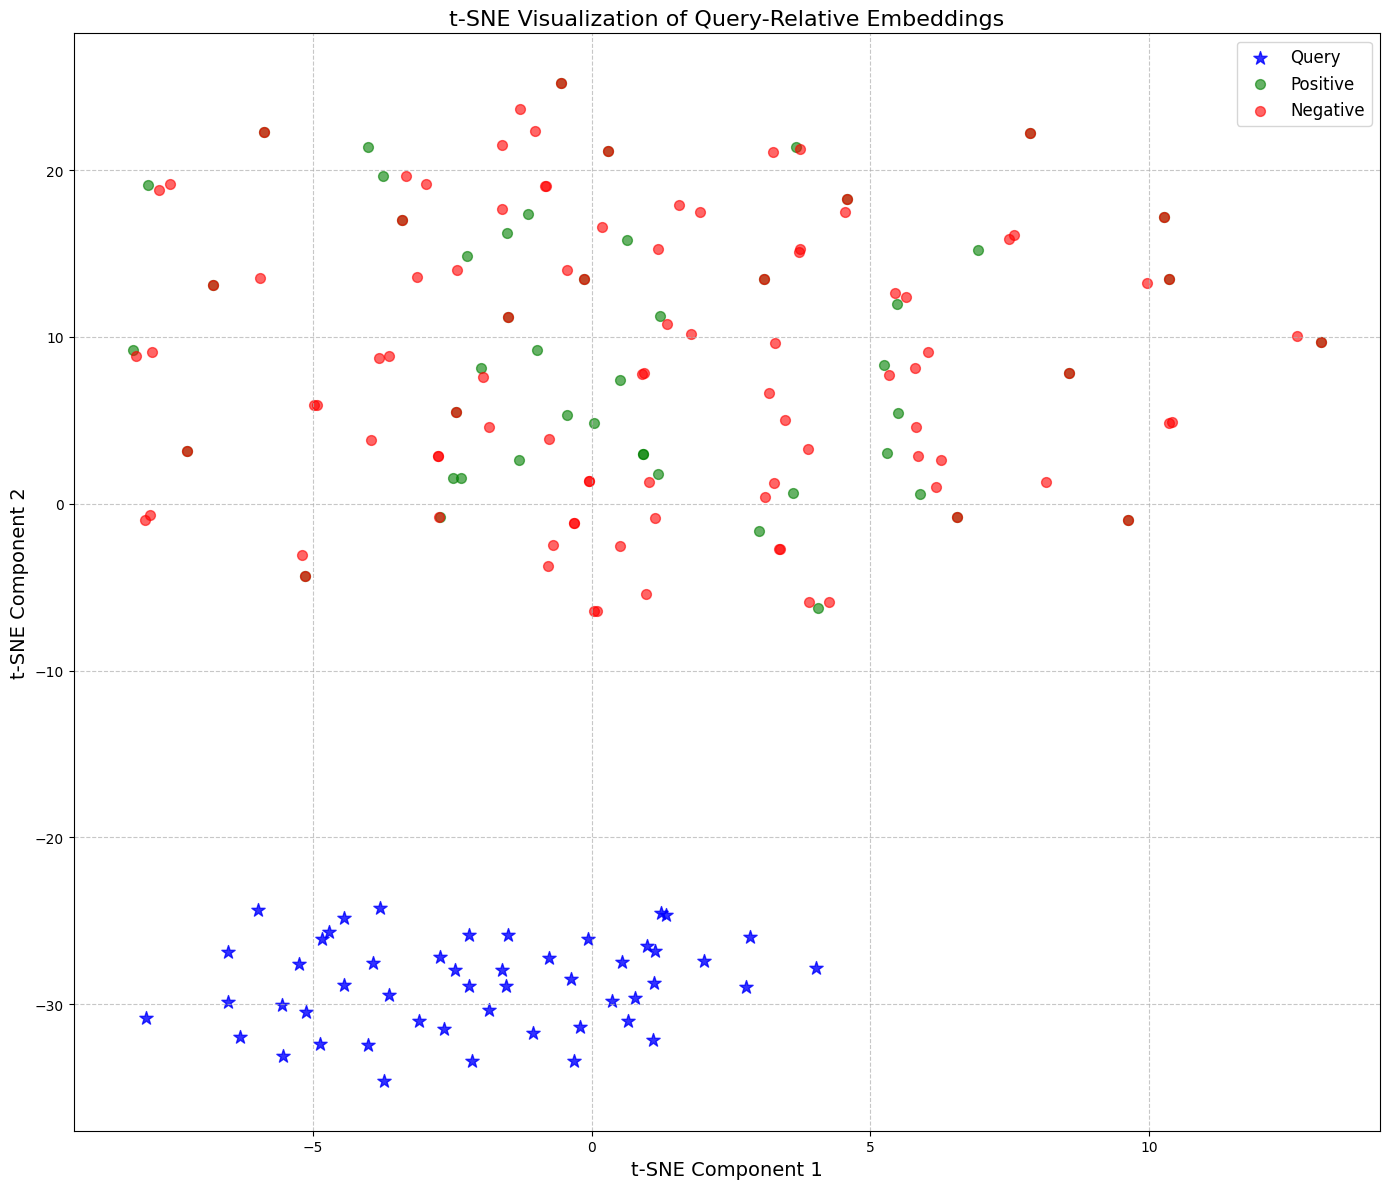

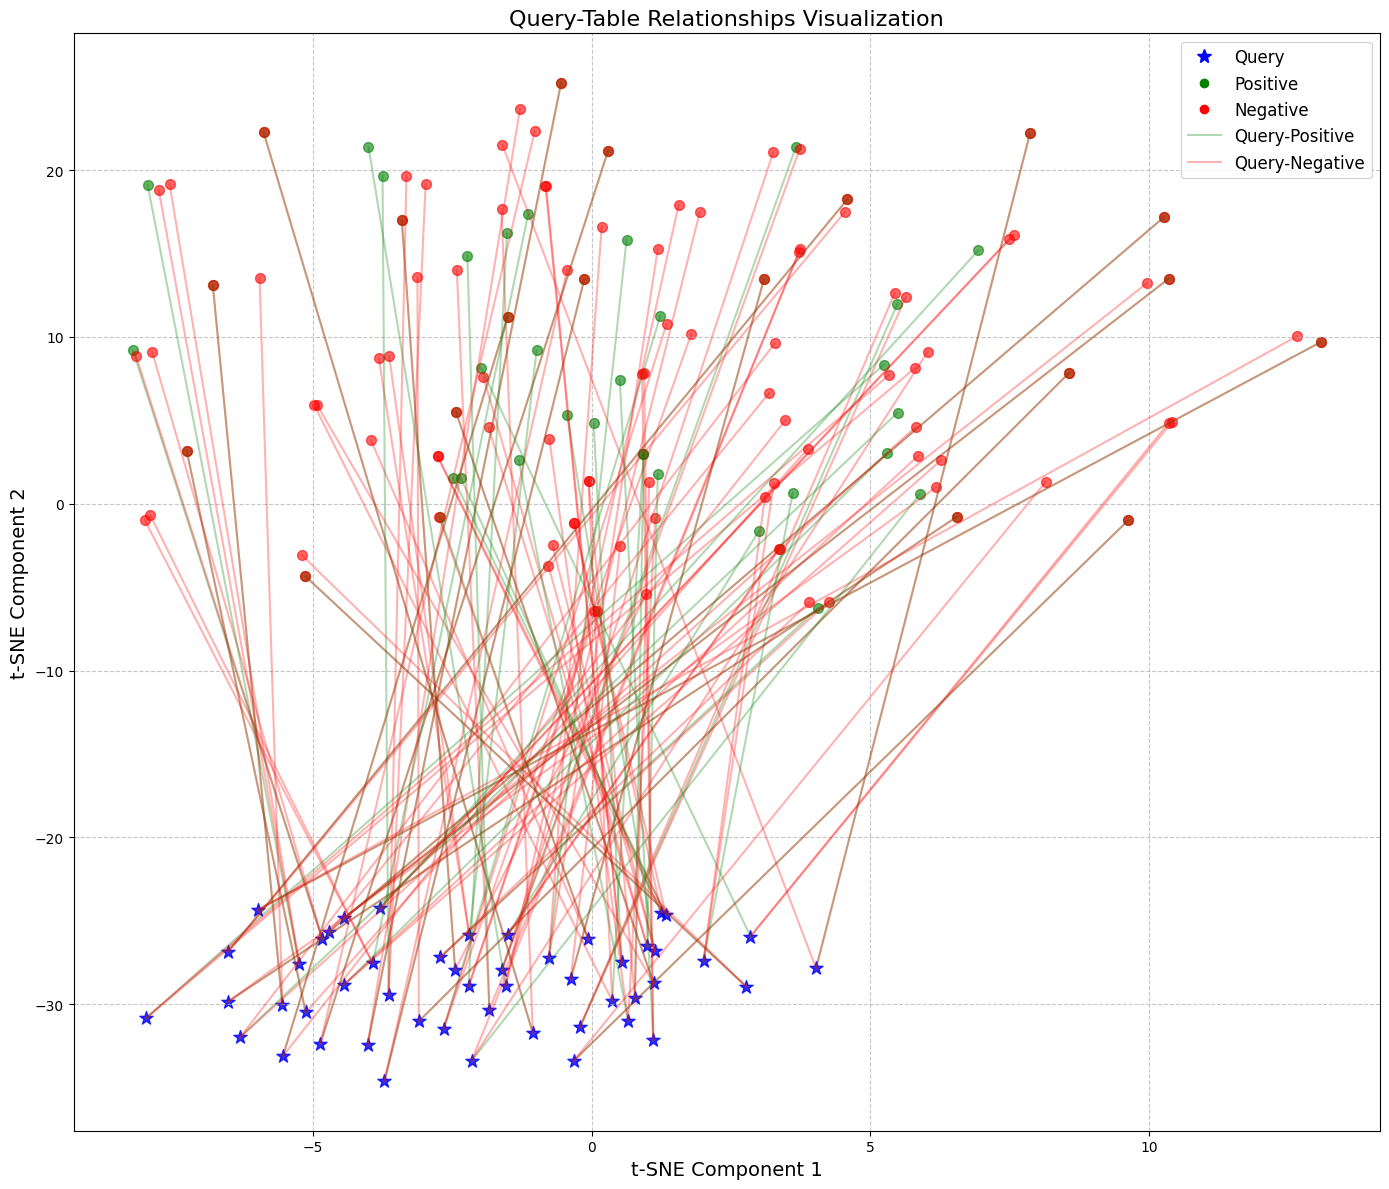

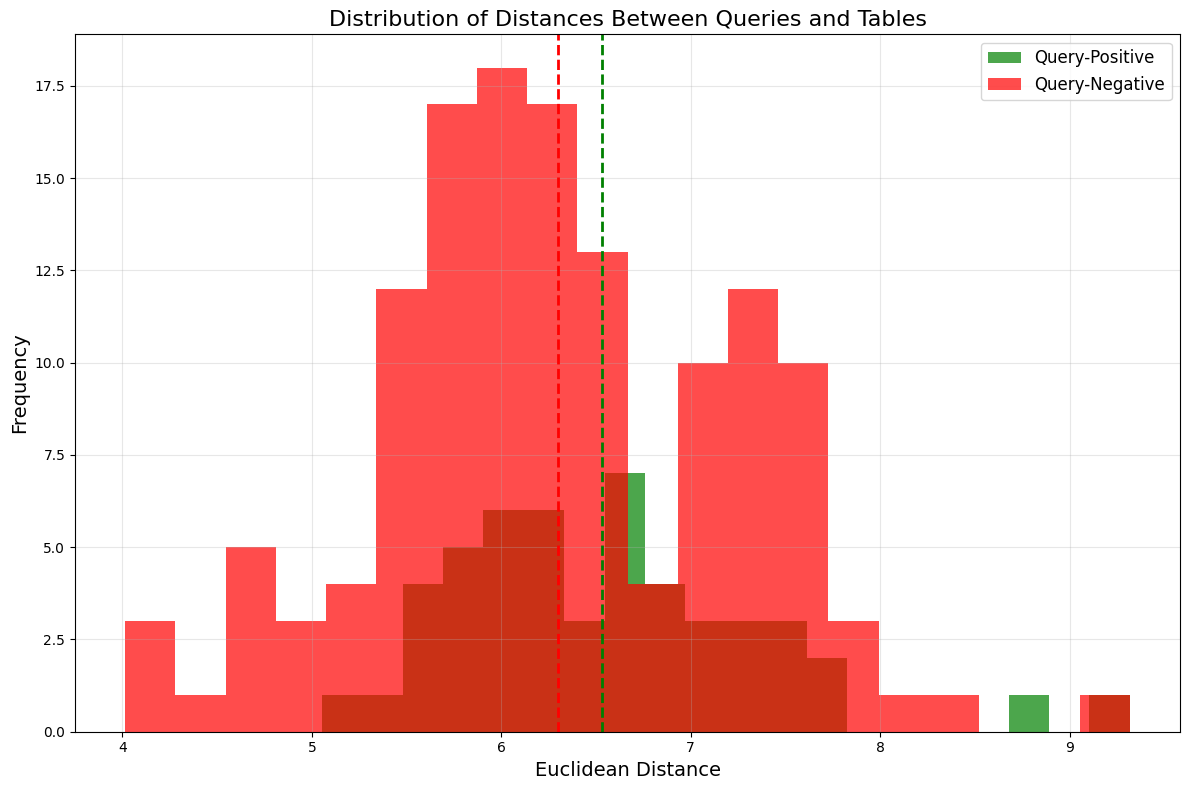


Distance Statistics:
Average Query-Positive Distance: 6.5305
Average Query-Negative Distance: 6.2974
Query-Positive / Query-Negative Ratio: 1.0370

Similarity Statistics:
Average Query-Positive Similarity: 0.9059
Average Query-Negative Similarity: 0.9077
Similarity Difference (Pos - Neg): -0.0018


In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import faiss
import json
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
import matplotlib.lines as mlines

# Load the FAISS indices
print("Loading FAISS indices...")
positive_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/positive_tables_index.faiss")
negative_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/negative_tables_index.faiss")
query_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/queries_index.faiss")  # Load query index too

# Load metadata for context
print("Loading metadata...")
with open("positive_metadata.json", "r") as f:
    positive_metadata = json.load(f)
with open("negative_metadata.json", "r") as f:
    negative_metadata = json.load(f)
with open("query_metadata.json", "r") as f:
    query_metadata = json.load(f)

# Extract embeddings from indices
print(f"Extracting embeddings from positive index ({positive_index.ntotal} vectors)...")
positive_embeddings = np.zeros((positive_index.ntotal, positive_index.d), dtype=np.float32)
for i in range(positive_index.ntotal):
    positive_embeddings[i] = positive_index.reconstruct(i)

print(f"Extracting embeddings from negative index ({negative_index.ntotal} vectors)...")
negative_embeddings = np.zeros((negative_index.ntotal, negative_index.d), dtype=np.float32)
for i in range(negative_index.ntotal):
    negative_embeddings[i] = negative_index.reconstruct(i)

print(f"Extracting embeddings from query index ({query_index.ntotal} vectors)...")
query_embeddings = np.zeros((query_index.ntotal, query_index.d), dtype=np.float32)
for i in range(query_index.ntotal):
    query_embeddings[i] = query_index.reconstruct(i)

print(f"Positive embeddings shape: {positive_embeddings.shape}")
print(f"Negative embeddings shape: {negative_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

# Create mappings from qid to indices
qid_to_query_idx = {}
for idx, item in enumerate(query_metadata):
    qid = item.get("qid")
    if qid:
        if qid not in qid_to_query_idx:
            qid_to_query_idx[qid] = []
        qid_to_query_idx[qid].append(idx)

qid_to_pos_idx = {}
for idx, item in enumerate(positive_metadata):
    qid = item.get("qid")
    if qid:
        if qid not in qid_to_pos_idx:
            qid_to_pos_idx[qid] = []
        qid_to_pos_idx[qid].append(idx)

qid_to_neg_idx = {}
for idx, item in enumerate(negative_metadata):
    qid = item.get("qid")
    if qid:
        if qid not in qid_to_neg_idx:
            qid_to_neg_idx[qid] = []
        qid_to_neg_idx[qid].append(idx)

# Find common qids across all three sets
common_qids = set(qid_to_query_idx.keys()) & set(qid_to_pos_idx.keys()) & set(qid_to_neg_idx.keys())
print(f"Found {len(common_qids)} common query IDs with query, positive, and negative embeddings")

# Sample some qids for visualization (to avoid clutter)
max_qids = 50
if len(common_qids) > max_qids:
    common_qids = random.sample(list(common_qids), max_qids)

# Create triplets: (query, positive, negative) for each common qid
triplets = []
query_embs = []
pos_embs = []
neg_embs = []

for qid in common_qids:
    query_idx = qid_to_query_idx[qid][0]  # Take first query embedding
    pos_idx = qid_to_pos_idx[qid][0]      # Take first positive embedding
    
    # Take up to 2 negative embeddings per query to avoid clutter
    neg_indices = qid_to_neg_idx[qid][:min(2, len(qid_to_neg_idx[qid]))]
    
    query_emb = query_embeddings[query_idx]
    pos_emb = positive_embeddings[pos_idx]
    
    query_embs.append(query_emb)
    pos_embs.append(pos_emb)
    
    for neg_idx in neg_indices:
        neg_emb = negative_embeddings[neg_idx]
        neg_embs.append(neg_emb)
        triplets.append((query_emb, pos_emb, neg_emb, qid))

print(f"Created {len(triplets)} triplets for visualization")

# Convert to numpy arrays
query_embs = np.array(query_embs)
pos_embs = np.array(pos_embs)
neg_embs = np.array(neg_embs)

# Combine all embeddings for dimensionality reduction
all_embeddings = np.vstack([query_embs, pos_embs, neg_embs])
labels = ['Query'] * len(query_embs) + ['Positive'] * len(pos_embs) + ['Negative'] * len(neg_embs)

# Apply dimensionality reduction
print("Applying PCA for visualization...")
pca = PCA(n_components=50)  # First reduce to 50 dimensions
pca_result = pca.fit_transform(all_embeddings)

print("Applying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(pca_result)

# Split t-SNE results back into queries, positives, and negatives
query_tsne = tsne_result[:len(query_embs)]
pos_tsne = tsne_result[len(query_embs):len(query_embs)+len(pos_embs)]
neg_tsne = tsne_result[len(query_embs)+len(pos_embs):]

# Create visualization
plt.figure(figsize=(14, 12))

# Plot points
plt.scatter(query_tsne[:, 0], query_tsne[:, 1], c='blue', label='Query', s=100, alpha=0.8, marker='*')
plt.scatter(pos_tsne[:, 0], pos_tsne[:, 1], c='green', label='Positive', s=50, alpha=0.6)
plt.scatter(neg_tsne[:, 0], neg_tsne[:, 1], c='red', label='Negative', s=50, alpha=0.6)

plt.title('t-SNE Visualization of Query-Relative Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a second visualization showing relationships with lines
plt.figure(figsize=(14, 12))

# Plot points
plt.scatter(query_tsne[:, 0], query_tsne[:, 1], c='blue', s=100, alpha=0.8, marker='*')
plt.scatter(pos_tsne[:, 0], pos_tsne[:, 1], c='green', s=50, alpha=0.6)
plt.scatter(neg_tsne[:, 0], neg_tsne[:, 1], c='red', s=50, alpha=0.6)

# Draw lines from queries to their positive and negative examples
neg_idx = 0
for i, q_coord in enumerate(query_tsne):
    # Draw line to positive example (green)
    p_coord = pos_tsne[i]
    plt.plot([q_coord[0], p_coord[0]], [q_coord[1], p_coord[1]], 'g-', alpha=0.3)
    
    # Draw lines to negative examples (red) - up to 2 per query
    neg_count = min(2, len(qid_to_neg_idx.get(common_qids[i], [])))
    for j in range(neg_count):
        if neg_idx < len(neg_tsne):
            n_coord = neg_tsne[neg_idx]
            plt.plot([q_coord[0], n_coord[0]], [q_coord[1], n_coord[1]], 'r-', alpha=0.3)
            neg_idx += 1

# Create custom legend
query_marker = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',
                          markersize=10, label='Query')
pos_marker = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=6, label='Positive')
neg_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=6, label='Negative')
pos_line = mlines.Line2D([], [], color='green', marker='None', linestyle='-',
                         alpha=0.3, label='Query-Positive')
neg_line = mlines.Line2D([], [], color='red', marker='None', linestyle='-',
                         alpha=0.3, label='Query-Negative')

plt.legend(handles=[query_marker, pos_marker, neg_marker, pos_line, neg_line], fontsize=12)
plt.title('Query-Table Relationships Visualization', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate and visualize the distances
query_pos_distances = []
query_neg_distances = []

for i, q_emb in enumerate(query_embs):
    # Distance to positive
    p_emb = pos_embs[i]
    query_pos_distances.append(np.linalg.norm(q_emb - p_emb))
    
    # Distances to negatives - find all negatives for this query
    qid = common_qids[i]
    for neg_idx in qid_to_neg_idx.get(qid, []):
        n_emb = negative_embeddings[neg_idx]
        query_neg_distances.append(np.linalg.norm(q_emb - n_emb))

# Plot histogram of distances
plt.figure(figsize=(12, 8))
plt.hist(query_pos_distances, bins=20, alpha=0.7, label='Query-Positive', color='green')
plt.hist(query_neg_distances, bins=20, alpha=0.7, label='Query-Negative', color='red')
plt.axvline(np.mean(query_pos_distances), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(query_neg_distances), color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Distances Between Queries and Tables', fontsize=16)
plt.xlabel('Euclidean Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nDistance Statistics:")
print(f"Average Query-Positive Distance: {np.mean(query_pos_distances):.4f}")
print(f"Average Query-Negative Distance: {np.mean(query_neg_distances):.4f}")
print(f"Query-Positive / Query-Negative Ratio: {np.mean(query_pos_distances) / np.mean(query_neg_distances):.4f}")

# Calculate cosine similarities
query_pos_sims = []
query_neg_sims = []

for i, q_emb in enumerate(query_embs):
    # Similarity to positive
    p_emb = pos_embs[i]
    sim = cosine_similarity([q_emb], [p_emb])[0][0]
    query_pos_sims.append(sim)
    
    # Similarities to negatives
    qid = common_qids[i]
    for neg_idx in qid_to_neg_idx.get(qid, []):
        n_emb = negative_embeddings[neg_idx]
        sim = cosine_similarity([q_emb], [n_emb])[0][0]
        query_neg_sims.append(sim)

print("\nSimilarity Statistics:")
print(f"Average Query-Positive Similarity: {np.mean(query_pos_sims):.4f}")
print(f"Average Query-Negative Similarity: {np.mean(query_neg_sims):.4f}")
print(f"Similarity Difference (Pos - Neg): {np.mean(query_pos_sims) - np.mean(query_neg_sims):.4f}")

Loading FAISS indices...
Loading metadata...
Extracting embeddings from positive index (9530 vectors)...
Extracting embeddings from negative index (25625 vectors)...
Extracting embeddings from query index (9530 vectors)...
Positive embeddings shape: (9530, 1024)
Negative embeddings shape: (25625, 1024)
Query embeddings shape: (9530, 1024)
Found 9530 common query IDs with query, positive, and negative embeddings
Created 100 triplets for visualization
Applying PCA for visualization...
Applying t-SNE for visualization...


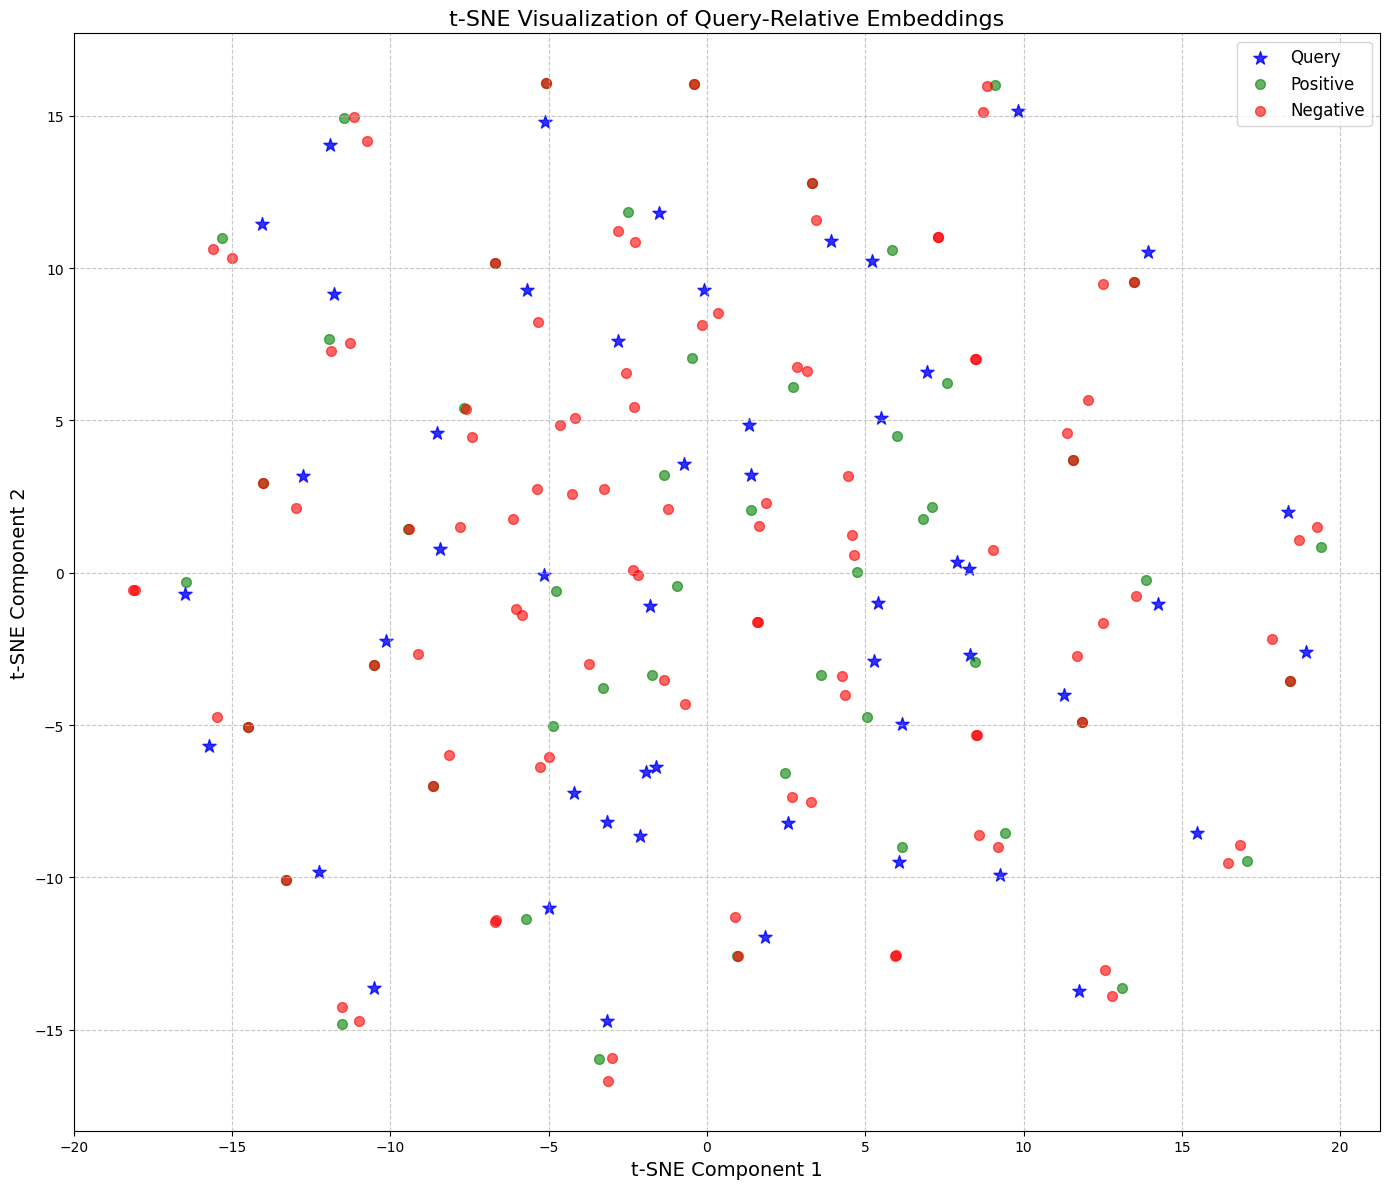

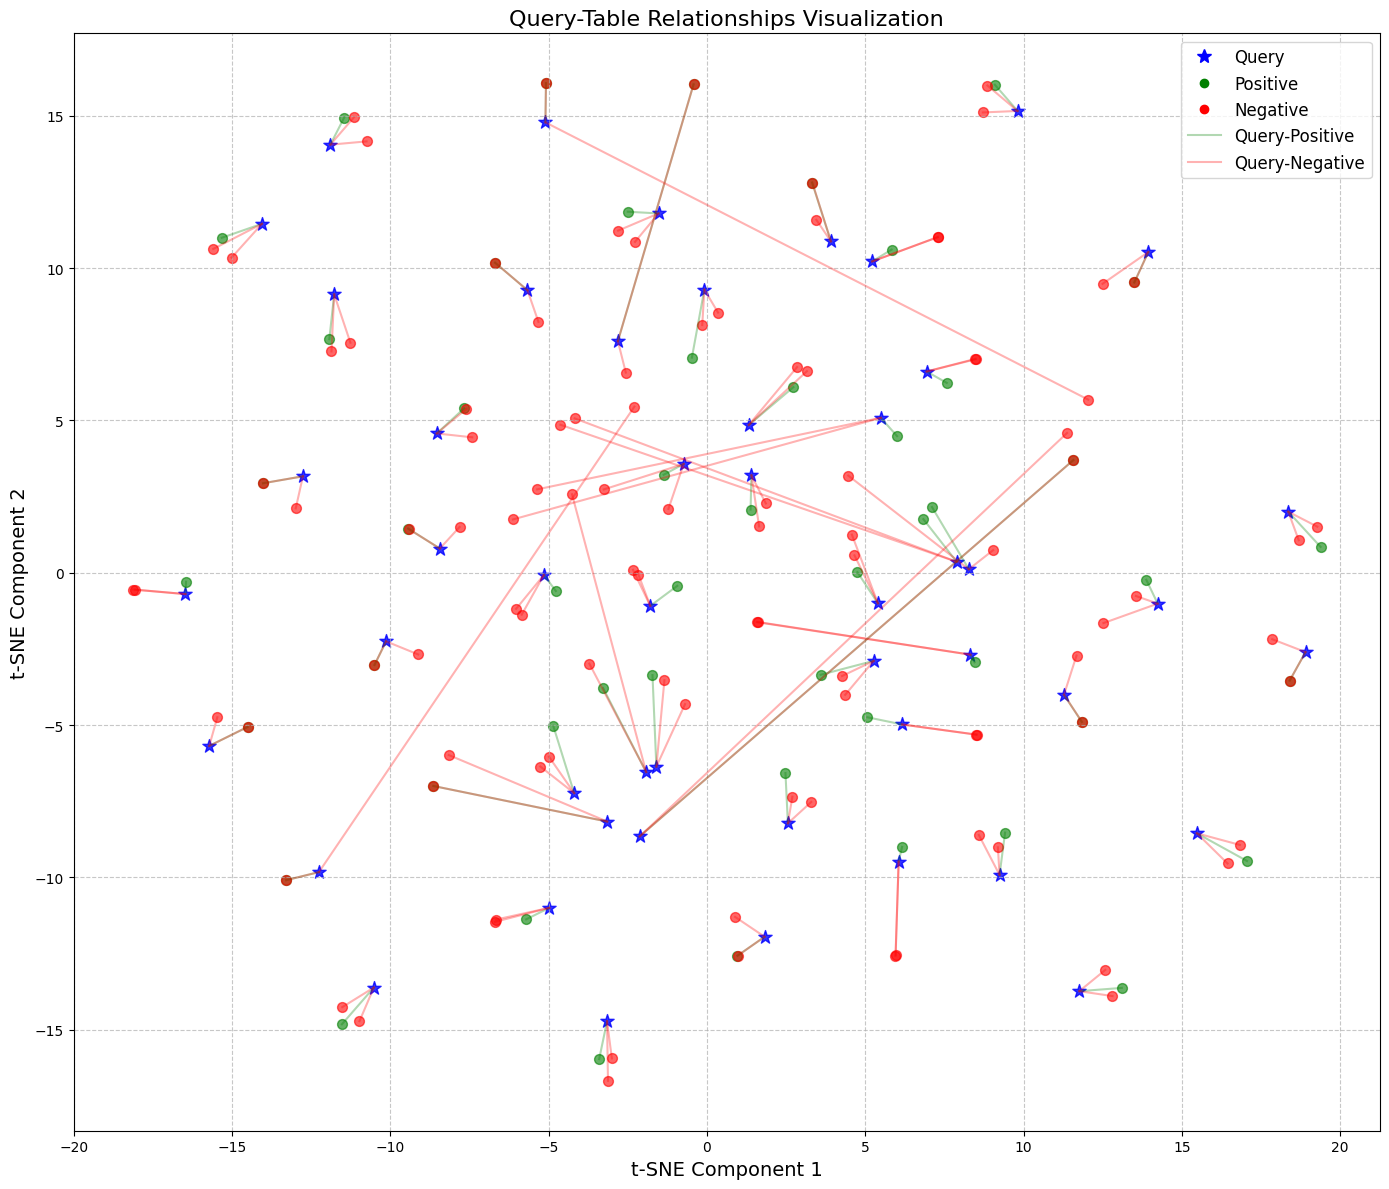

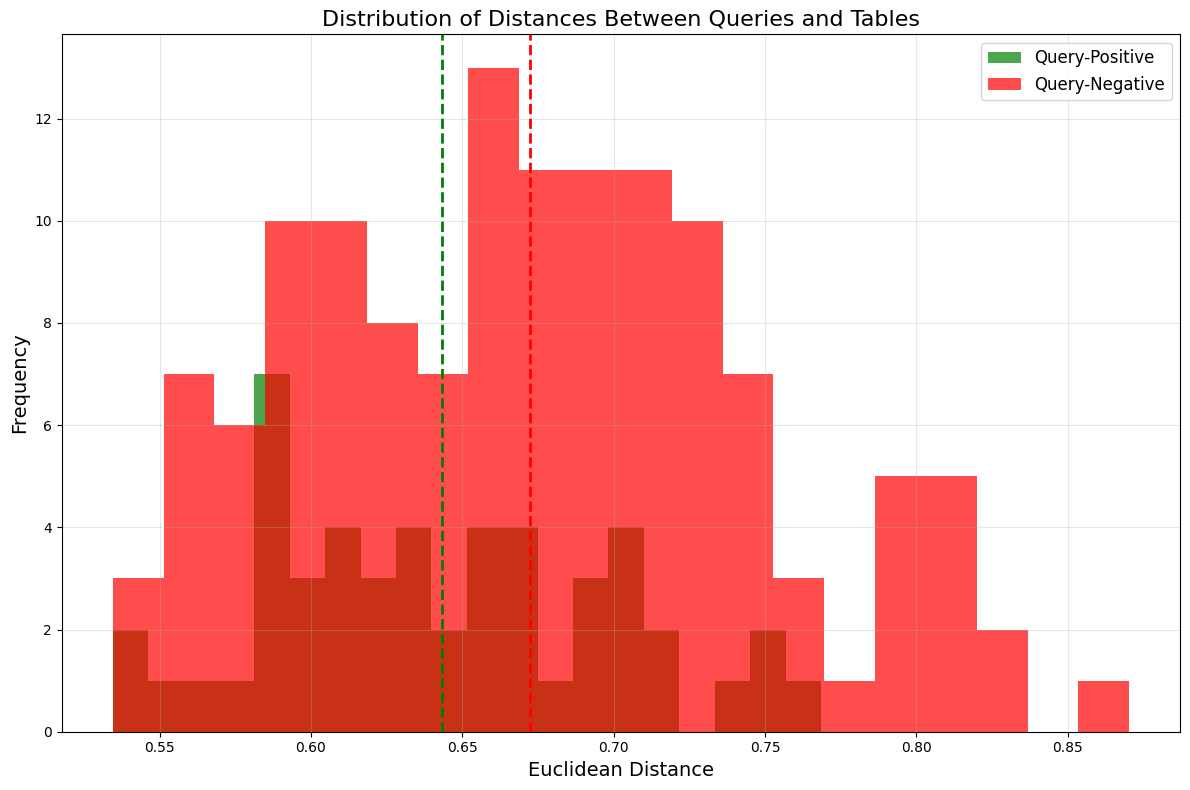


Distance Statistics:
Average Query-Positive Distance: 0.6432
Average Query-Negative Distance: 0.6724
Query-Positive / Query-Negative Ratio: 0.9566

Similarity Statistics:
Average Query-Positive Similarity: 0.7915
Average Query-Negative Similarity: 0.7712
Similarity Difference (Pos - Neg): 0.0203


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import faiss
import json
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
import matplotlib.lines as mlines

# Load the FAISS indices
print("Loading FAISS indices...")
positive_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss")
negative_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss")
query_index = faiss.read_index("/home/mvyas7/TRIM-QA/Summer-Research/e5_queries_index.faiss")  # Load query index too

# Load metadata for context
print("Loading metadata...")
with open("positive_metadata.json", "r") as f:
    positive_metadata = json.load(f)
with open("negative_metadata.json", "r") as f:
    negative_metadata = json.load(f)
with open("query_metadata.json", "r") as f:
    query_metadata = json.load(f)

# Extract embeddings from indices
print(f"Extracting embeddings from positive index ({positive_index.ntotal} vectors)...")
positive_embeddings = np.zeros((positive_index.ntotal, positive_index.d), dtype=np.float32)
for i in range(positive_index.ntotal):
    positive_embeddings[i] = positive_index.reconstruct(i)

print(f"Extracting embeddings from negative index ({negative_index.ntotal} vectors)...")
negative_embeddings = np.zeros((negative_index.ntotal, negative_index.d), dtype=np.float32)
for i in range(negative_index.ntotal):
    negative_embeddings[i] = negative_index.reconstruct(i)

print(f"Extracting embeddings from query index ({query_index.ntotal} vectors)...")
query_embeddings = np.zeros((query_index.ntotal, query_index.d), dtype=np.float32)
for i in range(query_index.ntotal):
    query_embeddings[i] = query_index.reconstruct(i)

print(f"Positive embeddings shape: {positive_embeddings.shape}")
print(f"Negative embeddings shape: {negative_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

# Create mappings from qid to indices
qid_to_query_idx = {}
for idx, item in enumerate(query_metadata):
    qid = item.get("qid")
    if qid:
        if qid not in qid_to_query_idx:
            qid_to_query_idx[qid] = []
        qid_to_query_idx[qid].append(idx)

qid_to_pos_idx = {}
for idx, item in enumerate(positive_metadata):
    qid = item.get("qid")
    if qid:
        if qid not in qid_to_pos_idx:
            qid_to_pos_idx[qid] = []
        qid_to_pos_idx[qid].append(idx)

qid_to_neg_idx = {}
for idx, item in enumerate(negative_metadata):
    qid = item.get("qid")
    if qid:
        if qid not in qid_to_neg_idx:
            qid_to_neg_idx[qid] = []
        qid_to_neg_idx[qid].append(idx)

# Find common qids across all three sets
common_qids = set(qid_to_query_idx.keys()) & set(qid_to_pos_idx.keys()) & set(qid_to_neg_idx.keys())
print(f"Found {len(common_qids)} common query IDs with query, positive, and negative embeddings")

# Sample some qids for visualization (to avoid clutter)
max_qids = 50
if len(common_qids) > max_qids:
    common_qids = random.sample(list(common_qids), max_qids)

# Create triplets: (query, positive, negative) for each common qid
triplets = []
query_embs = []
pos_embs = []
neg_embs = []

for qid in common_qids:
    query_idx = qid_to_query_idx[qid][0]  # Take first query embedding
    pos_idx = qid_to_pos_idx[qid][0]      # Take first positive embedding
    
    # Take up to 2 negative embeddings per query to avoid clutter
    neg_indices = qid_to_neg_idx[qid][:min(2, len(qid_to_neg_idx[qid]))]
    
    query_emb = query_embeddings[query_idx]
    pos_emb = positive_embeddings[pos_idx]
    
    query_embs.append(query_emb)
    pos_embs.append(pos_emb)
    
    for neg_idx in neg_indices:
        neg_emb = negative_embeddings[neg_idx]
        neg_embs.append(neg_emb)
        triplets.append((query_emb, pos_emb, neg_emb, qid))

print(f"Created {len(triplets)} triplets for visualization")

# Convert to numpy arrays
query_embs = np.array(query_embs)
pos_embs = np.array(pos_embs)
neg_embs = np.array(neg_embs)

# Combine all embeddings for dimensionality reduction
all_embeddings = np.vstack([query_embs, pos_embs, neg_embs])
labels = ['Query'] * len(query_embs) + ['Positive'] * len(pos_embs) + ['Negative'] * len(neg_embs)

# Apply dimensionality reduction
print("Applying PCA for visualization...")
pca = PCA(n_components=50)  # First reduce to 50 dimensions
pca_result = pca.fit_transform(all_embeddings)

print("Applying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(pca_result)

# Split t-SNE results back into queries, positives, and negatives
query_tsne = tsne_result[:len(query_embs)]
pos_tsne = tsne_result[len(query_embs):len(query_embs)+len(pos_embs)]
neg_tsne = tsne_result[len(query_embs)+len(pos_embs):]

# Create visualization
plt.figure(figsize=(14, 12))

# Plot points
plt.scatter(query_tsne[:, 0], query_tsne[:, 1], c='blue', label='Query', s=100, alpha=0.8, marker='*')
plt.scatter(pos_tsne[:, 0], pos_tsne[:, 1], c='green', label='Positive', s=50, alpha=0.6)
plt.scatter(neg_tsne[:, 0], neg_tsne[:, 1], c='red', label='Negative', s=50, alpha=0.6)

plt.title('t-SNE Visualization of Query-Relative Embeddings', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a second visualization showing relationships with lines
plt.figure(figsize=(14, 12))

# Plot points
plt.scatter(query_tsne[:, 0], query_tsne[:, 1], c='blue', s=100, alpha=0.8, marker='*')
plt.scatter(pos_tsne[:, 0], pos_tsne[:, 1], c='green', s=50, alpha=0.6)
plt.scatter(neg_tsne[:, 0], neg_tsne[:, 1], c='red', s=50, alpha=0.6)

# Draw lines from queries to their positive and negative examples
neg_idx = 0
for i, q_coord in enumerate(query_tsne):
    # Draw line to positive example (green)
    p_coord = pos_tsne[i]
    plt.plot([q_coord[0], p_coord[0]], [q_coord[1], p_coord[1]], 'g-', alpha=0.3)
    
    # Draw lines to negative examples (red) - up to 2 per query
    neg_count = min(2, len(qid_to_neg_idx.get(common_qids[i], [])))
    for j in range(neg_count):
        if neg_idx < len(neg_tsne):
            n_coord = neg_tsne[neg_idx]
            plt.plot([q_coord[0], n_coord[0]], [q_coord[1], n_coord[1]], 'r-', alpha=0.3)
            neg_idx += 1

# Create custom legend
query_marker = mlines.Line2D([], [], color='blue', marker='*', linestyle='None',
                          markersize=10, label='Query')
pos_marker = mlines.Line2D([], [], color='green', marker='o', linestyle='None',
                          markersize=6, label='Positive')
neg_marker = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=6, label='Negative')
pos_line = mlines.Line2D([], [], color='green', marker='None', linestyle='-',
                         alpha=0.3, label='Query-Positive')
neg_line = mlines.Line2D([], [], color='red', marker='None', linestyle='-',
                         alpha=0.3, label='Query-Negative')

plt.legend(handles=[query_marker, pos_marker, neg_marker, pos_line, neg_line], fontsize=12)
plt.title('Query-Table Relationships Visualization', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate and visualize the distances
query_pos_distances = []
query_neg_distances = []

for i, q_emb in enumerate(query_embs):
    # Distance to positive
    p_emb = pos_embs[i]
    query_pos_distances.append(np.linalg.norm(q_emb - p_emb))
    
    # Distances to negatives - find all negatives for this query
    qid = common_qids[i]
    for neg_idx in qid_to_neg_idx.get(qid, []):
        n_emb = negative_embeddings[neg_idx]
        query_neg_distances.append(np.linalg.norm(q_emb - n_emb))

# Plot histogram of distances
plt.figure(figsize=(12, 8))
plt.hist(query_pos_distances, bins=20, alpha=0.7, label='Query-Positive', color='green')
plt.hist(query_neg_distances, bins=20, alpha=0.7, label='Query-Negative', color='red')
plt.axvline(np.mean(query_pos_distances), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(query_neg_distances), color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Distances Between Queries and Tables', fontsize=16)
plt.xlabel('Euclidean Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("\nDistance Statistics:")
print(f"Average Query-Positive Distance: {np.mean(query_pos_distances):.4f}")
print(f"Average Query-Negative Distance: {np.mean(query_neg_distances):.4f}")
print(f"Query-Positive / Query-Negative Ratio: {np.mean(query_pos_distances) / np.mean(query_neg_distances):.4f}")

# Calculate cosine similarities
query_pos_sims = []
query_neg_sims = []

for i, q_emb in enumerate(query_embs):
    # Similarity to positive
    p_emb = pos_embs[i]
    sim = cosine_similarity([q_emb], [p_emb])[0][0]
    query_pos_sims.append(sim)
    
    # Similarities to negatives
    qid = common_qids[i]
    for neg_idx in qid_to_neg_idx.get(qid, []):
        n_emb = negative_embeddings[neg_idx]
        sim = cosine_similarity([q_emb], [n_emb])[0][0]
        query_neg_sims.append(sim)

print("\nSimilarity Statistics:")
print(f"Average Query-Positive Similarity: {np.mean(query_pos_sims):.4f}")
print(f"Average Query-Negative Similarity: {np.mean(query_neg_sims):.4f}")
print(f"Similarity Difference (Pos - Neg): {np.mean(query_pos_sims) - np.mean(query_neg_sims):.4f}")

In [ ]:
# 

Starting triplet model training with FAISS embeddings...
Loading metadata from triplet_embeddings_data.json...
Loading FAISS indices...
Loading metadata mappings...
Creating mappings from query IDs to FAISS indices...
Dataset ready with 9530 valid triplets
Splitting data into training and validation sets...
Training set size: 7624, Validation set size: 1906
Embedding dimension from FAISS index: 1024
Initializing encoder model...
Setting up training parameters...
Beginning model training...


Validation: 100%|██████████| 120/120 [00:00<00:00, 1320.64it/s]


Epoch [1/20], Train Loss: 0.6527, Val Loss: 0.6293
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1322.38it/s]


Epoch [2/20], Train Loss: 0.5700, Val Loss: 0.5799
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1306.00it/s]


Epoch [3/20], Train Loss: 0.5332, Val Loss: 0.6056


Validation: 100%|██████████| 120/120 [00:00<00:00, 1329.43it/s]


Epoch [4/20], Train Loss: 0.5260, Val Loss: 0.5754
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1314.16it/s]


Epoch [5/20], Train Loss: 0.5144, Val Loss: 0.5725
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1331.01it/s]


Epoch [6/20], Train Loss: 0.4993, Val Loss: 0.5590
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1338.72it/s]


Epoch [7/20], Train Loss: 0.4835, Val Loss: 0.5711


Validation: 100%|██████████| 120/120 [00:00<00:00, 1333.24it/s]


Epoch [8/20], Train Loss: 0.4702, Val Loss: 0.5497
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1324.00it/s]


Epoch [9/20], Train Loss: 0.4620, Val Loss: 0.5695


Validation: 100%|██████████| 120/120 [00:00<00:00, 1312.96it/s]


Epoch [10/20], Train Loss: 0.4531, Val Loss: 0.5636


Validation: 100%|██████████| 120/120 [00:00<00:00, 1332.33it/s]


Epoch [11/20], Train Loss: 0.4485, Val Loss: 0.5574


Validation: 100%|██████████| 120/120 [00:00<00:00, 1328.07it/s]


Epoch [12/20], Train Loss: 0.4257, Val Loss: 0.5865


Validation: 100%|██████████| 120/120 [00:00<00:00, 1319.22it/s]


Epoch [13/20], Train Loss: 0.4387, Val Loss: 0.5505


Validation: 100%|██████████| 120/120 [00:00<00:00, 1326.17it/s]


Epoch [14/20], Train Loss: 0.4227, Val Loss: 0.5616


Validation: 100%|██████████| 120/120 [00:00<00:00, 1312.77it/s]


Epoch [15/20], Train Loss: 0.4140, Val Loss: 0.5474
Model saved to best_model.pth


Validation: 100%|██████████| 120/120 [00:00<00:00, 1337.35it/s]


Epoch [16/20], Train Loss: 0.4038, Val Loss: 0.5874


Validation: 100%|██████████| 120/120 [00:00<00:00, 1336.27it/s]


Epoch [17/20], Train Loss: 0.3999, Val Loss: 0.5830


Validation: 100%|██████████| 120/120 [00:00<00:00, 1315.40it/s]


Epoch [18/20], Train Loss: 0.3951, Val Loss: 0.5824


Validation: 100%|██████████| 120/120 [00:00<00:00, 1336.90it/s]


Epoch [19/20], Train Loss: 0.3867, Val Loss: 0.5897


Validation: 100%|██████████| 120/120 [00:00<00:00, 1324.30it/s]


Epoch [20/20], Train Loss: 0.3898, Val Loss: 0.5910
Training complete.
Plotting training and validation losses...


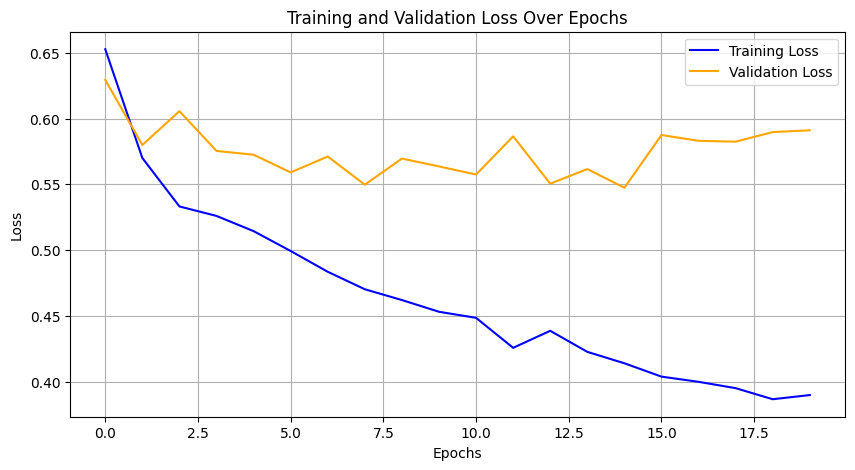

Saving final model...
Model saved to triplet_encoder_final.pth
Training process complete!


In [ ]:
# """
# Triplet Learning Model for Table Retrieval using FAISS embeddings

# This code implements a triplet learning architecture to improve table retrieval.
# It trains a neural network to encode query and table embeddings in a way that
# semantically related queries and tables are closer together in the embedding space,
# while unrelated tables are pushed further apart.
# """

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, random_split
# import json
# import numpy as np
# import faiss
# from typing import Dict, List
# from tqdm import tqdm

# class FAISSTripletDataset(Dataset):
#     """
#     Dataset class that loads embeddings directly from FAISS indices
#     and maps them to the metadata from the JSON file.
#     """
#     def __init__(self, metadata_file: str, 
#                  query_index_path: str, 
#                  positive_index_path: str, 
#                  negative_index_path: str):
#         print(f"Loading metadata from {metadata_file}...")
#         with open(metadata_file, "r") as f:
#             self.metadata = json.load(f)
        
#         print(f"Loading FAISS indices...")
#         self.query_index = faiss.read_index(query_index_path)
#         self.positive_index = faiss.read_index(positive_index_path)
#         self.negative_index = faiss.read_index(negative_index_path)
        
#         print(f"Loading metadata mappings...")
#         with open("e5_positive_metadata.json", "r") as f:
#             self.positive_metadata = json.load(f)
#         with open("e5_negative_metadata.json", "r") as f:
#             self.negative_metadata = json.load(f)
#         with open("e5_query_metadata.json", "r") as f:
#             self.query_metadata = json.load(f)
        
#         print("Creating mappings from query IDs to FAISS indices...")
#         # Create mappings from qid to index in FAISS
#         self.qid_to_query_idx = {}
#         for idx, item in enumerate(self.query_metadata):
#             self.qid_to_query_idx[item["qid"]] = idx
        
#         self.qid_to_pos_idx = {}
#         for idx, item in enumerate(self.positive_metadata):
#             if item["qid"] not in self.qid_to_pos_idx:
#                 self.qid_to_pos_idx[item["qid"]] = []
#             self.qid_to_pos_idx[item["qid"]].append(idx)
        
#         self.qid_to_neg_idx = {}
#         for idx, item in enumerate(self.negative_metadata):
#             if item["qid"] not in self.qid_to_neg_idx:
#                 self.qid_to_neg_idx[item["qid"]] = []
#             self.qid_to_neg_idx[item["qid"]].append(idx)
        
#         # Store list of valid qids (those with query, positive, and negative embeddings)
#         self.valid_qids = [qid for qid in self.metadata.keys() 
#                           if qid in self.qid_to_query_idx 
#                           and qid in self.qid_to_pos_idx 
#                           and qid in self.qid_to_neg_idx]
        
#         print(f"Dataset ready with {len(self.valid_qids)} valid triplets")

#     def __len__(self):
#         return len(self.valid_qids)

#     def __getitem__(self, idx: int) -> tuple:
#         qid = self.valid_qids[idx]
        
#         # Get query embedding
#         query_idx = self.qid_to_query_idx[qid]
#         query_embedding = self._get_vector_from_index(self.query_index, query_idx)
        
#         # Get positive embedding
#         pos_idx = self.qid_to_pos_idx[qid][0]  # Take the first positive embedding
#         pos_embedding = self._get_vector_from_index(self.positive_index, pos_idx)
        
#         # Get negative embeddings
#         neg_indices = self.qid_to_neg_idx[qid]
#         neg_embeddings = [self._get_vector_from_index(self.negative_index, neg_idx) 
#                          for neg_idx in neg_indices]
        
#         return query_embedding, pos_embedding, neg_embeddings
    
#     def _get_vector_from_index(self, index, idx):
#         """Get a single vector from a FAISS index by its position."""
#         if hasattr(index, 'reconstruct'):
#             return index.reconstruct(idx)
#         else:
#             # For flat indices that don't have reconstruct method
#             arr = np.empty((1, index.d), dtype=np.float32)
#             index.reconstruct_n(idx, 1, arr)
#             return arr[0]
    
#     def get_query(self, idx: int) -> str:
#         qid = self.valid_qids[idx]
#         return self.metadata[qid]["query"]
    
#     def get_positive_table_id(self, idx: int) -> str:
#         qid = self.valid_qids[idx]
#         return self.metadata[qid]["positive_table_id"]
    
#     def get_hard_negatives(self, idx: int) -> List[str]:
#         qid = self.valid_qids[idx]
#         return self.metadata[qid]["hard_negatives"]
    
#     def get_positive_content(self, idx: int) -> str:
#         qid = self.valid_qids[idx]
#         return self.metadata[qid].get("positive_content", "")
    
#     def get_negative_contents(self, idx: int) -> List[str]:
#         qid = self.valid_qids[idx]
#         return self.metadata[qid].get("negative_contents", [])

# class TripletEncoder(nn.Module):
#     """
#     Neural network model that transforms input embeddings into a lower-dimensional space.
#     """
#     def __init__(self, embedding_dim: int):
#         super(TripletEncoder, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(embedding_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.fc(x)
    
# class TripletLoss(nn.Module):
#     """
#     Custom triplet loss implementation that maximizes the distance between anchor-negative pairs
#     while minimizing the distance between anchor-positive pairs.
#     """
#     def __init__(self, margin: float = 1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
#         pos_distance = torch.norm(anchor - positive, p=2, dim=1)
#         neg_distance = torch.norm(anchor - negative, p=2, dim=1)
#         # Triplet loss formula: max(0, distance(anchor, positive) - distance(anchor, negative) + margin)
#         losses = torch.clamp(pos_distance - neg_distance + self.margin, min=0.0)
#         return losses.mean()
    
# class TripletTrainer:
#     """
#     Trainer class that handles the training and evaluation of the TripletEncoder model.
#     """
#     def __init__(self, model: nn.Module, train_data: Dataset, val_data: Dataset, batch_size: int = 32, learning_rate: float = 0.001, num_epochs: int = 10, margin: float = 1.0):
#         self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.model = model.to(self.device)
#         self.train_data = train_data
#         self.val_data = val_data
#         self.batch_size = batch_size
#         self.learning_rate = learning_rate
#         self.num_epochs = num_epochs
#         self.criterion = TripletLoss(margin=margin)
#         self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
#         self.train_dataloader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)
#         self.val_dataloader = DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
#         self.train_losses = []
#         self.val_losses = []

#     def collate_fn(self, batch):
#         # Each item in batch is (query_emb, pos_emb, list_of_neg_embs)
#         # We select one negative for each positive
#         anchors, positives, negatives = [], [], []
#         for anchor, positive, neg_embs in batch:
#             if neg_embs:  # ensure there is at least one negative
#                 anchors.append(anchor)
#                 positives.append(positive)
#                 # Select a random negative from the list
#                 negatives.append(neg_embs[np.random.randint(len(neg_embs))])

#         if not anchors:
#             return None, None, None

#         anchors = torch.tensor(np.array(anchors), dtype=torch.float32)
#         positives = torch.tensor(np.array(positives), dtype=torch.float32)
#         negatives = torch.tensor(np.array(negatives), dtype=torch.float32)
#         return anchors, positives, negatives

#     def train(self):
#         best_val_loss = float('inf')
#         for epoch in range(self.num_epochs):
#             self.model.train()
#             total_train_loss = 0.0
#             batch_count = 0
            
#             for anchor, positive, negative in tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.num_epochs} Training"):
#                 if anchor is None: continue
#                 anchor, positive, negative = anchor.to(self.device), positive.to(self.device), negative.to(self.device)
                
#                 self.optimizer.zero_grad()
                
#                 anchor_embedding = self.model(anchor)
#                 positive_embedding = self.model(positive)
#                 negative_embedding = self.model(negative)
                
#                 loss = self.criterion(anchor_embedding, positive_embedding, negative_embedding)
#                 loss.backward()
#                 self.optimizer.step()
                
#                 total_train_loss += loss.item()
#                 batch_count += 1

#             avg_train_loss = total_train_loss / batch_count if batch_count > 0 else 0
#             avg_val_loss = self.validate()

#             self.train_losses.append(avg_train_loss)
#             self.val_losses.append(avg_val_loss)
            
#             print(f"Epoch [{epoch+1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

#             if avg_val_loss < best_val_loss:
#                 best_val_loss = avg_val_loss
#                 self.save_model("best_model.pth")
        
#         print("Training complete.")
#         return best_val_loss, self.train_losses, self.val_losses


#     def validate(self):
#         self.model.eval()
#         total_val_loss = 0.0
#         batch_count = 0
        
#         with torch.no_grad():
#             for anchor, positive, negative in tqdm(self.val_dataloader, desc="Validation"):
#                 if anchor is None: continue
#                 anchor, positive, negative = anchor.to(self.device), positive.to(self.device), negative.to(self.device)
                
#                 anchor_embedding = self.model(anchor)
#                 positive_embedding = self.model(positive)
#                 negative_embedding = self.model(negative)
                
#                 loss = self.criterion(anchor_embedding, positive_embedding, negative_embedding)
#                 total_val_loss += loss.item()
#                 batch_count += 1
        
#         return total_val_loss / batch_count if batch_count > 0 else 0

#     def save_model(self, path: str):
#         torch.save(self.model.state_dict(), path)
#         print(f"Model saved to {path}")

#     def load_model(self, path: str):
#         self.model.load_state_dict(torch.load(path, map_location=self.device))
#         self.model.eval()
#         print(f"Model loaded from {path}")
 
#  # a class for plotting the training and validation loss
# class TrainingPlotter:
#     """
#     Class to handle plotting of training and validation loss over epochs.
#     """
#     def __init__(self):
#         self.train_losses = []
#         self.val_losses = []

#     def update(self, train_loss: float, val_loss: float):
#         self.train_losses.append(train_loss)
#         self.val_losses.append(val_loss)

#     def plot(self):
#         import matplotlib.pyplot as plt
        
#         plt.figure(figsize=(10, 5))
#         plt.plot(self.train_losses, label='Training Loss', color='blue')
#         plt.plot(self.val_losses, label='Validation Loss', color='orange')
#         plt.xlabel('Epochs')
#         plt.ylabel('Loss')
#         plt.title('Training and Validation Loss Over Epochs')
#         plt.legend()
#         plt.grid()
#         plt.show()

# def main():
#     """
#     Main execution function that handles data loading, model initialization,
#     training, and saving the final model for inference.
#     """
#     print("Starting triplet model training with FAISS embeddings...")
    
#     # Step 1: Data Preparation - Load embeddings from FAISS indices
#     try:
#         triplet_dataset = FAISSTripletDataset(
#             metadata_file="triplet_embeddings_data.json",
#             query_index_path="/home/mvyas7/TRIM-QA/Summer-Research/e5_queries_index.faiss",
#             positive_index_path="/home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss",
#             negative_index_path="/home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss"
#         )
#     except Exception as e:
#         print(f"Error loading dataset: {e}")
#         raise e
    
#     # Split dataset into training and validation
#     print("Splitting data into training and validation sets...")
#     train_size = int(0.8 * len(triplet_dataset))
#     val_size = len(triplet_dataset) - train_size
#     train_dataset, val_dataset = random_split(triplet_dataset, [train_size, val_size])
#     print(f"Training set size: {train_size}, Validation set size: {val_size}")
    
#     # Get the embedding dimension from the FAISS index
#     embedding_dim = triplet_dataset.query_index.d
#     print(f"Embedding dimension from FAISS index: {embedding_dim}")
    
#     # Step 2: Model Architecture - Initialize encoder network
#     print("Initializing encoder model...")
#     model = TripletEncoder(embedding_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
    
#     # Step 3 & 4: Loss Function & Training Loop - Initialize trainer with triplet loss
#     print("Setting up training parameters...")
#     trainer = TripletTrainer(
#         model=model, 
#         train_data=train_dataset, 
#         val_data=val_dataset, 
#         batch_size=16, 
#         learning_rate=2e-3, # Adjusted learning rate for better convergence
#         num_epochs=20,
#         margin=1.0  # Hyperparameter defining how far apart positive and negative pairs should be
#     )

#     # Initialise the plotter
#     plotter = TrainingPlotter()

#     # Train the model
#     print("Beginning model training...")
#     best_val_losses, train_losses, val_losses = trainer.train()

#     # Update the plotter with training and validation losses
#     for train_loss, val_loss in zip(train_losses, val_losses):
#         plotter.update(train_loss, val_loss)

#     # Plot the training and validation losses
#     print("Plotting training and validation losses...")
#     plotter.plot()
    
#     # Save the trained model for inference
#     print("Saving final model...")
#     trainer.save_model("triplet_encoder_final.pth")
#     print("Training process complete!")

# if __name__ == "__main__":
#     main()

<!-- ### Training for Dense embeddings E5 -->


Loading dataset...
Loading metadata from e5_triplet_embeddings_data.json...
Loading FAISS indices...
Loading metadata mappings...
Creating mappings from query IDs to FAISS indices...
Dataset ready with 9530 valid triplets
Starting triplet model training with optimized parameters...
Training set size: 7624, Validation set size: 1906
Embedding dimension from FAISS index: 1024
Training model with optimized hyperparameters...


Validation: 100%|██████████| 60/60 [00:00<00:00, 658.26it/s]


Epoch [1/30], Train Loss: 0.6941, Val Loss: 0.6930, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.6930, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 698.40it/s]


Epoch [2/30], Train Loss: 0.6940, Val Loss: 0.6930, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.6930, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 687.09it/s]


Epoch [3/30], Train Loss: 0.6680, Val Loss: 0.5550, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5550, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 698.52it/s]


Epoch [4/30], Train Loss: 0.5641, Val Loss: 0.5325, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5325, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 697.30it/s]


Epoch [5/30], Train Loss: 0.5333, Val Loss: 0.5220, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5220, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 698.30it/s]


Epoch [6/30], Train Loss: 0.5247, Val Loss: 0.5212, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5212, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 701.02it/s]


Epoch [7/30], Train Loss: 0.5199, Val Loss: 0.5147, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5147, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 699.95it/s]


Epoch [8/30], Train Loss: 0.5232, Val Loss: 0.5227, LR: 0.005000


Validation: 100%|██████████| 60/60 [00:00<00:00, 690.22it/s]


Epoch [9/30], Train Loss: 0.5274, Val Loss: 0.5285, LR: 0.005000


Validation: 100%|██████████| 60/60 [00:00<00:00, 697.04it/s]


Epoch [10/30], Train Loss: 0.5071, Val Loss: 0.5066, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5066, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 674.63it/s]


Epoch [11/30], Train Loss: 0.5087, Val Loss: 0.5060, LR: 0.005000
Model saved to best_model.pth
New best validation loss: 0.5060, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 682.47it/s]


Epoch [12/30], Train Loss: 0.5077, Val Loss: 0.5096, LR: 0.005000


Validation: 100%|██████████| 60/60 [00:00<00:00, 657.68it/s]


Epoch [13/30], Train Loss: 0.5175, Val Loss: 0.5189, LR: 0.005000


Validation: 100%|██████████| 60/60 [00:00<00:00, 720.74it/s]


Epoch [14/30], Train Loss: 0.5114, Val Loss: 0.5075, LR: 0.005000


Validation: 100%|██████████| 60/60 [00:00<00:00, 714.54it/s]


Epoch [15/30], Train Loss: 0.5023, Val Loss: 0.5102, LR: 0.002500


Validation: 100%|██████████| 60/60 [00:00<00:00, 675.94it/s]


Epoch [16/30], Train Loss: 0.4865, Val Loss: 0.4805, LR: 0.002500
Model saved to best_model.pth
New best validation loss: 0.4805, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 714.36it/s]


Epoch [17/30], Train Loss: 0.4829, Val Loss: 0.4909, LR: 0.002500


Validation: 100%|██████████| 60/60 [00:00<00:00, 689.14it/s]


Epoch [18/30], Train Loss: 0.4887, Val Loss: 0.4950, LR: 0.002500


Validation: 100%|██████████| 60/60 [00:00<00:00, 698.30it/s]


Epoch [19/30], Train Loss: 0.4846, Val Loss: 0.4818, LR: 0.002500


Validation: 100%|██████████| 60/60 [00:00<00:00, 705.15it/s]


Epoch [20/30], Train Loss: 0.4846, Val Loss: 0.4962, LR: 0.001250


Validation: 100%|██████████| 60/60 [00:00<00:00, 698.28it/s]


Epoch [21/30], Train Loss: 0.4665, Val Loss: 0.4872, LR: 0.001250


Validation: 100%|██████████| 60/60 [00:00<00:00, 691.42it/s]


Epoch [22/30], Train Loss: 0.4678, Val Loss: 0.4879, LR: 0.001250


Validation: 100%|██████████| 60/60 [00:00<00:00, 706.89it/s]


Epoch [23/30], Train Loss: 0.4617, Val Loss: 0.4803, LR: 0.001250
Model saved to best_model.pth
New best validation loss: 0.4803, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 659.24it/s]


Epoch [24/30], Train Loss: 0.4660, Val Loss: 0.4778, LR: 0.001250
Model saved to best_model.pth
New best validation loss: 0.4778, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 679.64it/s]


Epoch [25/30], Train Loss: 0.4568, Val Loss: 0.4844, LR: 0.001250


Validation: 100%|██████████| 60/60 [00:00<00:00, 674.27it/s]


Epoch [26/30], Train Loss: 0.4538, Val Loss: 0.4743, LR: 0.001250
Model saved to best_model.pth
New best validation loss: 0.4743, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 722.27it/s]


Epoch [27/30], Train Loss: 0.4585, Val Loss: 0.4815, LR: 0.001250


Validation: 100%|██████████| 60/60 [00:00<00:00, 613.34it/s]


Epoch [28/30], Train Loss: 0.4459, Val Loss: 0.4719, LR: 0.001250
Model saved to best_model.pth
New best validation loss: 0.4719, model saved


Validation: 100%|██████████| 60/60 [00:00<00:00, 695.77it/s]


Epoch [29/30], Train Loss: 0.4520, Val Loss: 0.4862, LR: 0.001250


Validation: 100%|██████████| 60/60 [00:00<00:00, 712.35it/s]


Epoch [30/30], Train Loss: 0.4486, Val Loss: 0.4680, LR: 0.001250
Model saved to best_model.pth
New best validation loss: 0.4680, model saved
Training complete


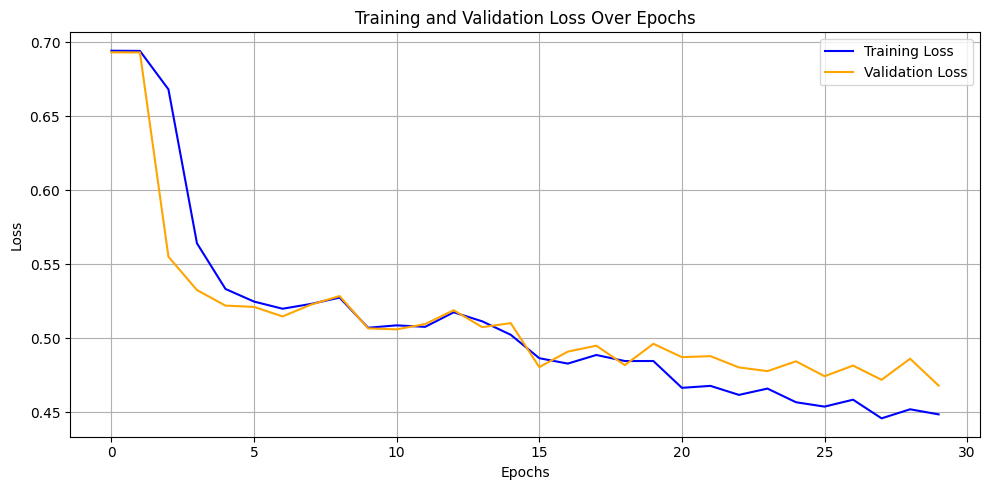

Model saved to optimized_triplet_model.pth
Training complete!
Model loaded from optimized_triplet_model.pth


Processing embeddings: 100%|██████████| 100/100 [00:00<00:00, 782.92it/s]


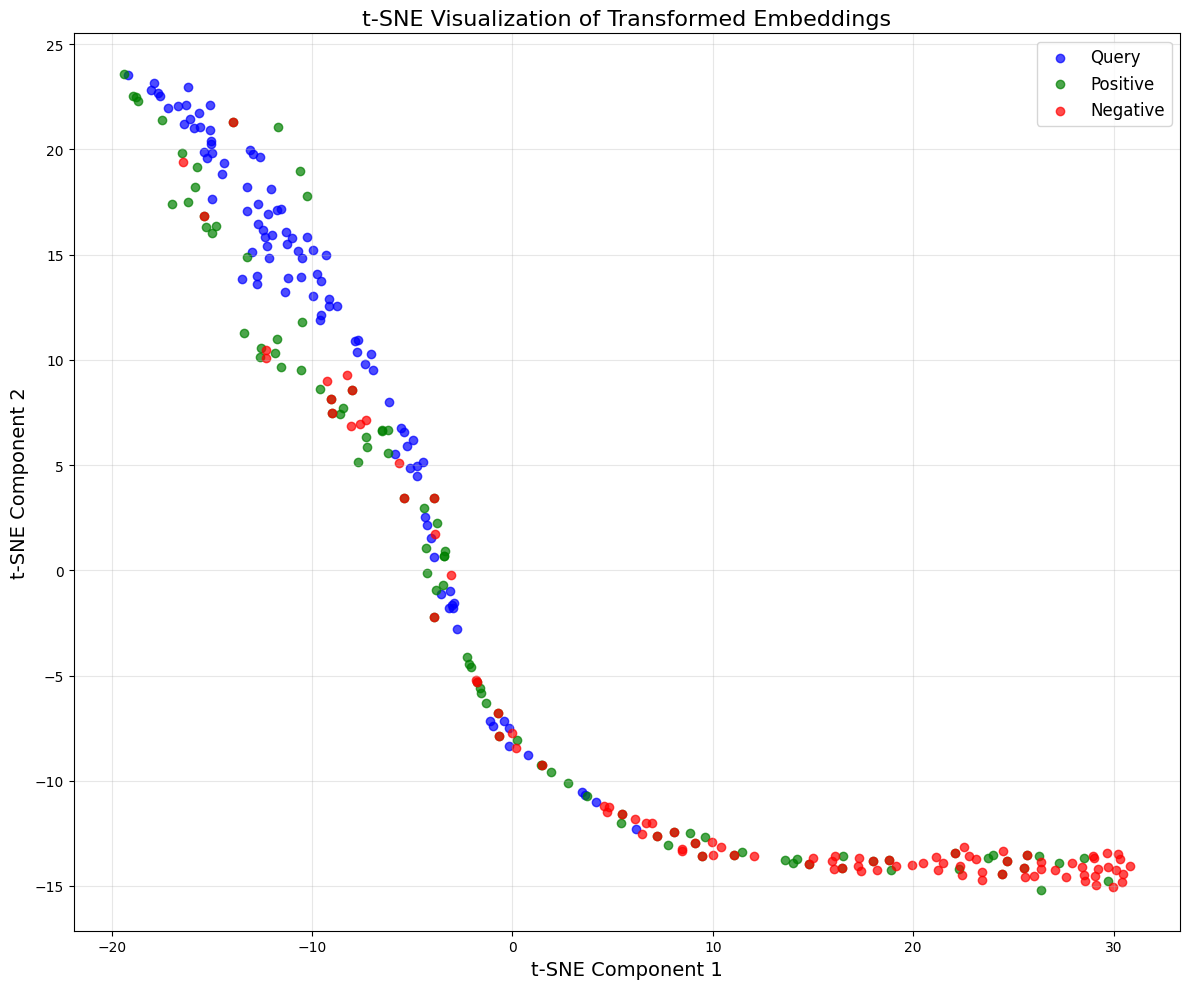


Distance Statistics:
Average Query-Positive Distance: 0.5741
Average Query-Negative Distance: 1.2917
Distance Ratio (Negative/Positive): 2.2499
Process completed successfully!


In [3]:
"""
Enhanced Triplet Learning Model for Table Retrieval using FAISS embeddings

This code implements a triplet learning architecture to improve table retrieval.
It trains a neural network to encode query and table embeddings in a way that
semantically related queries and tables are closer together in the embedding space,
while unrelated tables are pushed further apart.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import json
import numpy as np
import faiss
from typing import Dict, List, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import random
import os

class FAISSTripletDataset(Dataset):
    """
    Dataset class that loads embeddings directly from FAISS indices
    and maps them to the metadata from the JSON file.
    """
    def __init__(self, metadata_file: str, 
                 query_index_path: str, 
                 positive_index_path: str, 
                 negative_index_path: str):
        print(f"Loading metadata from {metadata_file}...")
        with open(metadata_file, "r") as f:
            self.metadata = json.load(f)
        
        print(f"Loading FAISS indices...")
        self.query_index = faiss.read_index(query_index_path)
        self.positive_index = faiss.read_index(positive_index_path)
        self.negative_index = faiss.read_index(negative_index_path)
        
        print(f"Loading metadata mappings...")
        # Extract metadata prefix from the metadata_file name
        prefix = metadata_file.split('_')[0] if '_' in metadata_file else ""
        metadata_prefix = f"{prefix}_" if prefix else ""
        
        with open(f"{metadata_prefix}positive_metadata.json", "r") as f:
            self.positive_metadata = json.load(f)
        with open(f"{metadata_prefix}negative_metadata.json", "r") as f:
            self.negative_metadata = json.load(f)
        with open(f"{metadata_prefix}query_metadata.json", "r") as f:
            self.query_metadata = json.load(f)
        
        print("Creating mappings from query IDs to FAISS indices...")
        # Create mappings from qid to index in FAISS
        self.qid_to_query_idx = {}
        for idx, item in enumerate(self.query_metadata):
            self.qid_to_query_idx[item["qid"]] = idx
        
        self.qid_to_pos_idx = {}
        for idx, item in enumerate(self.positive_metadata):
            if item["qid"] not in self.qid_to_pos_idx:
                self.qid_to_pos_idx[item["qid"]] = []
            self.qid_to_pos_idx[item["qid"]].append(idx)
        
        self.qid_to_neg_idx = {}
        for idx, item in enumerate(self.negative_metadata):
            if item["qid"] not in self.qid_to_neg_idx:
                self.qid_to_neg_idx[item["qid"]] = []
            self.qid_to_neg_idx[item["qid"]].append(idx)
        
        # Store list of valid qids (those with query, positive, and negative embeddings)
        self.valid_qids = [qid for qid in self.metadata.keys() 
                          if qid in self.qid_to_query_idx 
                          and qid in self.qid_to_pos_idx 
                          and qid in self.qid_to_neg_idx]
        
        print(f"Dataset ready with {len(self.valid_qids)} valid triplets")

    def __len__(self):
        return len(self.valid_qids)

    def __getitem__(self, idx: int) -> tuple:
        qid = self.valid_qids[idx]
        
        # Get query embedding
        query_idx = self.qid_to_query_idx[qid]
        query_embedding = self._get_vector_from_index(self.query_index, query_idx)
        
        # Get positive embedding
        pos_idx = self.qid_to_pos_idx[qid][0]  # Take the first positive embedding
        pos_embedding = self._get_vector_from_index(self.positive_index, pos_idx)
        
        # Get negative embeddings
        neg_indices = self.qid_to_neg_idx[qid]
        neg_embeddings = [self._get_vector_from_index(self.negative_index, neg_idx) 
                         for neg_idx in neg_indices]
        
        return query_embedding, pos_embedding, neg_embeddings
    
    def _get_vector_from_index(self, index, idx):
        """Get a single vector from a FAISS index by its position."""
        if hasattr(index, 'reconstruct'):
            return index.reconstruct(idx)
        else:
            # For flat indices that don't have reconstruct method
            arr = np.empty((1, index.d), dtype=np.float32)
            index.reconstruct_n(idx, 1, arr)
            return arr[0]
    
    def get_query(self, idx: int) -> str:
        qid = self.valid_qids[idx]
        return self.metadata[qid]["query"]
    
    def get_positive_table_id(self, idx: int) -> str:
        qid = self.valid_qids[idx]
        return self.metadata[qid]["positive_table_id"]
    
    def get_hard_negatives(self, idx: int) -> List[str]:
        qid = self.valid_qids[idx]
        return self.metadata[qid]["hard_negatives"]
    
    def get_positive_content(self, idx: int) -> str:
        qid = self.valid_qids[idx]
        return self.metadata[qid].get("positive_content", "")
    
    def get_negative_contents(self, idx: int) -> List[str]:
        qid = self.valid_qids[idx]
        return self.metadata[qid].get("negative_contents", [])

class EnhancedTripletEncoder(nn.Module):
    """
    Enhanced neural network model that transforms input embeddings into a lower-dimensional space.
    Uses LayerNorm instead of InstanceNorm to avoid issues with spatial dimensions.
    """
    def __init__(self, embedding_dim: int, dropout_rate: float = 0.2):
        super(EnhancedTripletEncoder, self).__init__()
        # First layer
        self.fc1 = nn.Linear(embedding_dim, 512)
        self.norm1 = nn.LayerNorm(512)  # LayerNorm works with any input shape
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second layer
        self.fc2 = nn.Linear(512, 256)
        self.norm2 = nn.LayerNorm(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Third layer
        self.fc3 = nn.Linear(256, 128)
        
        # L2 normalization of final embeddings
        self.normalize_output = True
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # First layer
        x = self.fc1(x)
        x = self.norm1(x)  # LayerNorm doesn't need extra dimensions
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Second layer
        x = self.fc2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Third layer
        x = self.fc3(x)
        
        # L2 normalization
        if self.normalize_output:
            x = F.normalize(x, p=2, dim=1)
            
        return x

class EnhancedTripletLoss(nn.Module):
    """
    Enhanced triplet loss implementation with options for hard or soft margin.
    """
    def __init__(self, margin: float = 0.3, soft_margin: bool = True):
        super(EnhancedTripletLoss, self).__init__()
        self.margin = margin
        self.soft_margin = soft_margin
        
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        # Calculate distances
        pos_distance = torch.norm(anchor - positive, p=2, dim=1)
        neg_distance = torch.norm(anchor - negative, p=2, dim=1)
        
        # Calculate loss based on the chosen margin type
        if self.soft_margin:
            # Soft margin triplet loss using logarithm
            loss = torch.log1p(torch.exp(pos_distance - neg_distance))
        else:
            # Hard margin with traditional triplet loss
            loss = torch.clamp(pos_distance - neg_distance + self.margin, min=0.0)
        
        return loss.mean()

class EnhancedTripletTrainer:
    """
    Enhanced trainer class with learning rate scheduling, early stopping, and more robust training procedures.
    """
    def __init__(self, model: nn.Module, train_data: Dataset, val_data: Dataset, 
                 batch_size: int = 32, learning_rate: float = 5e-3, num_epochs: int = 30, 
                 margin: float = 0.3, weight_decay: float = 1e-4, scheduler_patience: int = 3,
                 early_stopping_patience: int = 7, soft_margin: bool = True):
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = max(batch_size, 2)  # Ensure minimum batch size of 2
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weight_decay = weight_decay
        self.early_stopping_patience = early_stopping_patience
        self.scheduler_patience = scheduler_patience
        
        # Use the enhanced triplet loss
        self.criterion = EnhancedTripletLoss(margin=margin, soft_margin=soft_margin)
        
        # Optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=scheduler_patience
        )
        
        # Data loaders with safe collate function
        self.train_dataloader = DataLoader(
            self.train_data, 
            batch_size=self.batch_size, 
            shuffle=True, 
            collate_fn=self.safe_collate_fn
        )
        
        self.val_dataloader = DataLoader(
            self.val_data, 
            batch_size=self.batch_size, 
            shuffle=False, 
            collate_fn=self.safe_collate_fn
        )
        
        self.train_losses = []
        self.val_losses = []

    def safe_collate_fn(self, batch):
        """Collate function that ensures we have at least 2 samples in a batch for training"""
        anchors, positives, negatives = [], [], []
        
        for anchor, positive, neg_embs in batch:
            if not neg_embs:  # Skip if no negatives
                continue
                
            anchors.append(anchor)
            positives.append(positive)
            # Select a random negative
            negatives.append(neg_embs[np.random.randint(len(neg_embs))])
        
        # If we don't have enough samples, return None
        if len(anchors) < 2:
            return None, None, None
            
        anchors = torch.tensor(np.array(anchors), dtype=torch.float32)
        positives = torch.tensor(np.array(positives), dtype=torch.float32)
        negatives = torch.tensor(np.array(negatives), dtype=torch.float32)
        
        return anchors, positives, negatives

    def train(self):
        """Train the model with early stopping and learning rate scheduling"""
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            total_train_loss = 0.0
            batch_count = 0
            
            for anchor, positive, negative in tqdm(self.train_dataloader, desc=f"Epoch {epoch+1}/{self.num_epochs} Training"):
                if anchor is None or anchor.size(0) < 2:
                    # Skip batches with fewer than 2 samples
                    continue
                    
                anchor = anchor.to(self.device)
                positive = positive.to(self.device)
                negative = negative.to(self.device)
                
                self.optimizer.zero_grad()
                
                # Forward pass
                anchor_embedding = self.model(anchor)
                positive_embedding = self.model(positive)
                negative_embedding = self.model(negative)
                
                # Calculate loss
                loss = self.criterion(anchor_embedding, positive_embedding, negative_embedding)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.optimizer.step()
                
                total_train_loss += loss.item()
                batch_count += 1

            avg_train_loss = total_train_loss / batch_count if batch_count > 0 else 0
            
            # Validation phase
            avg_val_loss = self.validate()
            
            # Update learning rate based on validation performance
            self.scheduler.step(avg_val_loss)
            
            # Record losses
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            
            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            
            print(f"Epoch [{epoch+1}/{self.num_epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
                  f"LR: {current_lr:.6f}")
            
            # Check if we should save the model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                epochs_no_improve = 0
                self.save_model("best_model.pth")
                print(f"New best validation loss: {best_val_loss:.4f}, model saved")
            else:
                epochs_no_improve += 1
                
            # Early stopping
            if epochs_no_improve >= self.early_stopping_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        print("Training complete")
        return best_val_loss, self.train_losses, self.val_losses

    def validate(self):
        """Evaluate the model on validation data"""
        self.model.eval()
        total_val_loss = 0.0
        batch_count = 0
        
        with torch.no_grad():
            for anchor, positive, negative in tqdm(self.val_dataloader, desc="Validation"):
                if anchor is None or anchor.size(0) < 2:
                    # Skip batches with fewer than 2 samples
                    continue
                
                anchor = anchor.to(self.device)
                positive = positive.to(self.device)
                negative = negative.to(self.device)
                
                anchor_embedding = self.model(anchor)
                positive_embedding = self.model(positive)
                negative_embedding = self.model(negative)
                
                loss = self.criterion(anchor_embedding, positive_embedding, negative_embedding)
                total_val_loss += loss.item()
                batch_count += 1
        
        return total_val_loss / batch_count if batch_count > 0 else 0

    def save_model(self, path: str):
        """Save model weights to file"""
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path: str):
        """Load model weights from file"""
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.eval()
        print(f"Model loaded from {path}")

class TrainingPlotter:
    """Class to handle plotting of training and validation loss over epochs"""
    def __init__(self):
        self.train_losses = []
        self.val_losses = []

    def update(self, train_loss: float, val_loss: float):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss', color='blue')
        plt.plot(self.val_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('training_validation_loss.png')
        plt.show()

def run_optimized_training(dataset):
    """Run training with optimized hyperparameters"""
    print("Starting triplet model training with optimized parameters...")
    
    # Data split with seed for reproducibility
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    print(f"Training set size: {train_size}, Validation set size: {val_size}")
    
    # Get embedding dimension
    embedding_dim = dataset.query_index.d
    print(f"Embedding dimension from FAISS index: {embedding_dim}")
    
    # Create enhanced model with optimal parameters
    model = EnhancedTripletEncoder(
        embedding_dim=embedding_dim,
        dropout_rate=0.2
    ).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create trainer with optimized hyperparameters
    trainer = EnhancedTripletTrainer(
        model=model,
        train_data=train_dataset,
        val_data=val_dataset,
        batch_size=32,          # Larger batch size for better gradient estimates
        learning_rate=5e-3,     # Slightly higher learning rate
        num_epochs=30,          # More epochs with early stopping
        margin=0.3,             # Lower margin often works better
        soft_margin=True,       # Use soft margin for more stable training
        weight_decay=1e-4,      # L2 regularization
        scheduler_patience=3,   # LR reduction after 3 epochs without improvement
        early_stopping_patience=7  # Stop after 7 epochs without improvement
    )
    
    # Train model
    print("Training model with optimized hyperparameters...")
    _, train_losses, val_losses = trainer.train()
    
    # Plot results
    plotter = TrainingPlotter()
    for train_loss, val_loss in zip(train_losses, val_losses):
        plotter.update(train_loss, val_loss)
    plotter.plot()
    
    # Save final model
    trainer.save_model("optimized_triplet_model.pth")
    print("Training complete!")
    
    return trainer, model

def visualize_embeddings(model_path, dataset):
    """Visualize the embeddings after transformation through the model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Get embedding dimension
    embedding_dim = dataset.query_index.d
    
    # Load the model
    model = EnhancedTripletEncoder(embedding_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Sample a subset of data for visualization
    sample_size = min(100, len(dataset))
    indices = random.sample(range(len(dataset)), sample_size)
    
    # Get embeddings
    query_embeddings, positive_embeddings, negative_embeddings = [], [], []
    
    with torch.no_grad():
        for idx in tqdm(indices, desc="Processing embeddings"):
            query_emb, pos_emb, neg_embs = dataset[idx]
            
            # Convert to tensors
            query = torch.tensor(query_emb, dtype=torch.float32).unsqueeze(0).to(device)
            pos = torch.tensor(pos_emb, dtype=torch.float32).unsqueeze(0).to(device)
            
            # Transform through model
            query_out = model(query).cpu().numpy()
            pos_out = model(pos).cpu().numpy()
            
            query_embeddings.append(query_out[0])
            positive_embeddings.append(pos_out[0])
            
            # Process one negative embedding per triplet
            if neg_embs:
                neg = torch.tensor(neg_embs[0], dtype=torch.float32).unsqueeze(0).to(device)
                neg_out = model(neg).cpu().numpy()
                negative_embeddings.append(neg_out[0])
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    
    # Combine all embeddings for t-SNE
    all_embeddings = np.vstack([query_embeddings, positive_embeddings, negative_embeddings])
    labels = ['Query'] * len(query_embeddings) + ['Positive'] * len(positive_embeddings) + ['Negative'] * len(negative_embeddings)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, sample_size-1))
    tsne_result = tsne.fit_transform(all_embeddings)
    
    # Plot points
    colors = {'Query': 'blue', 'Positive': 'green', 'Negative': 'red'}
    for label, color in colors.items():
        mask = [l == label for l in labels]
        plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=color, label=label, alpha=0.7)
    
    plt.title('t-SNE Visualization of Transformed Embeddings', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('embedding_visualization.png')
    plt.show()
    
    # Calculate and print distance statistics
    q_p_distances = []
    q_n_distances = []
    
    for q, p, n in zip(query_embeddings, positive_embeddings, negative_embeddings[:len(query_embeddings)]):
        q_p_distances.append(np.linalg.norm(q - p))
        q_n_distances.append(np.linalg.norm(q - n))
    
    print("\nDistance Statistics:")
    print(f"Average Query-Positive Distance: {np.mean(q_p_distances):.4f}")
    print(f"Average Query-Negative Distance: {np.mean(q_n_distances):.4f}")
    print(f"Distance Ratio (Negative/Positive): {np.mean(q_n_distances) / np.mean(q_p_distances):.4f}")

def main():
    """Main execution function with options for grid search or optimized training"""
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    print("Loading dataset...")
    triplet_dataset = FAISSTripletDataset(
        metadata_file="e5_triplet_embeddings_data.json",
        query_index_path="/home/mvyas7/TRIM-QA/Summer-Research/e5_queries_index.faiss",
        positive_index_path="/home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss",
        negative_index_path="/home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss"
    )
    
    # Run optimized training with tuned hyperparameters
    trainer, model = run_optimized_training(triplet_dataset)
    
    # Visualize the results
    visualize_embeddings("optimized_triplet_model.pth", triplet_dataset)
    
    print("Process completed successfully!")

if __name__ == "__main__":
    main()

Loading FAISS indices...
Loading indices from:
  - Queries: /home/mvyas7/TRIM-QA/Summer-Research/e5_queries_index.faiss
  - Positives: /home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss
  - Negatives: /home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss
  - Metadata: e5_triplet_embeddings_data.json
Embedding dimension from FAISS index: 1024
Detected embedding dimension from saved model: 1024
Model loaded from triplet_encoder_final.pth
Loading metadata from e5_triplet_embeddings_data.json...
Loading FAISS indices...
Loading metadata mappings...
Creating mappings from query IDs to FAISS indices...
Dataset ready with 9530 valid triplets
Total dataset size: 9530
Validation set size: 1906


Processing validation embeddings: 100%|██████████| 1906/1906 [00:01<00:00, 1721.95it/s]


Collected 1906 query, 1906 positive, and 1906 negative embeddings from validation set
Sampled 500 points for clearer visualization
Applying t-SNE for visualization...


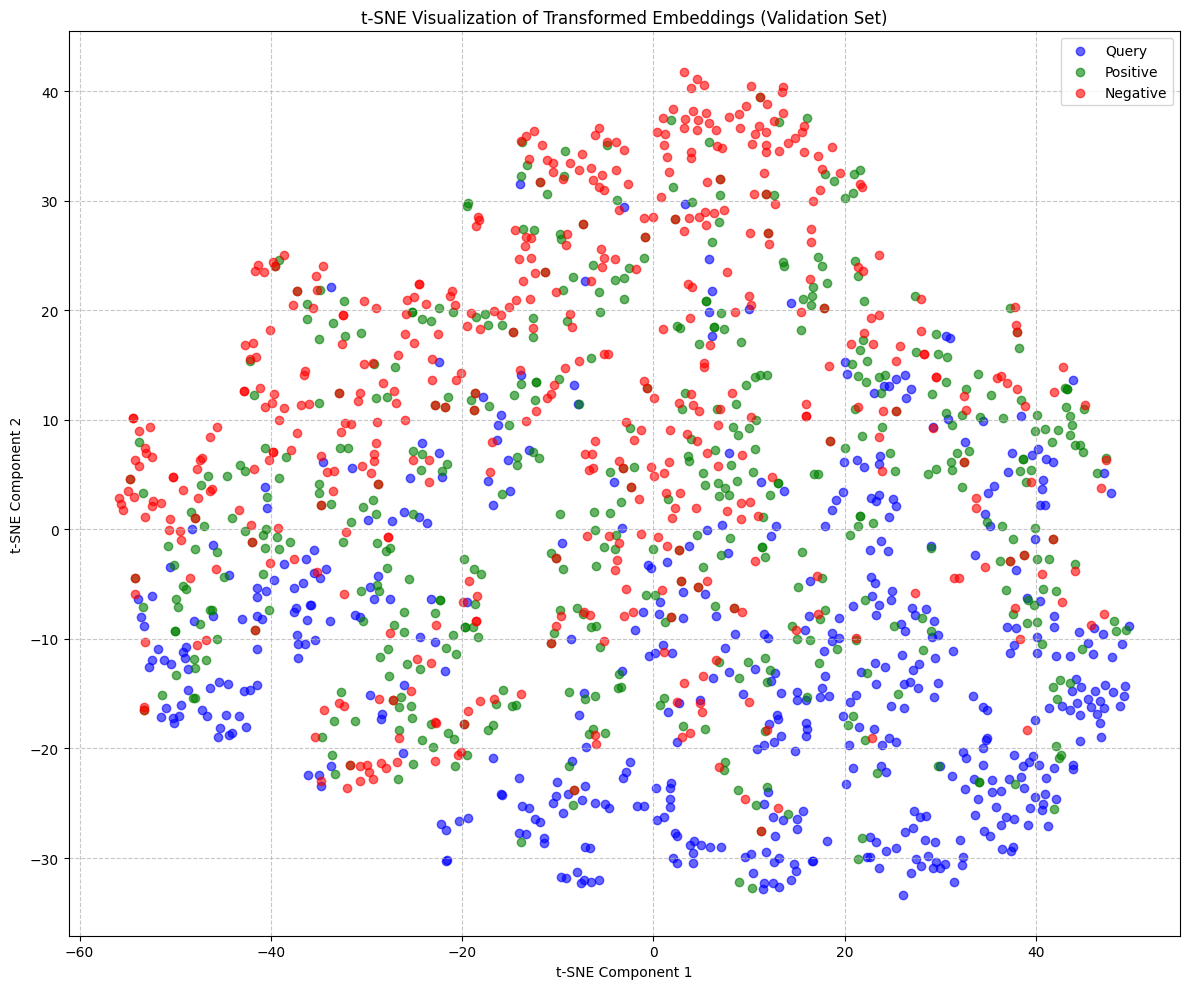

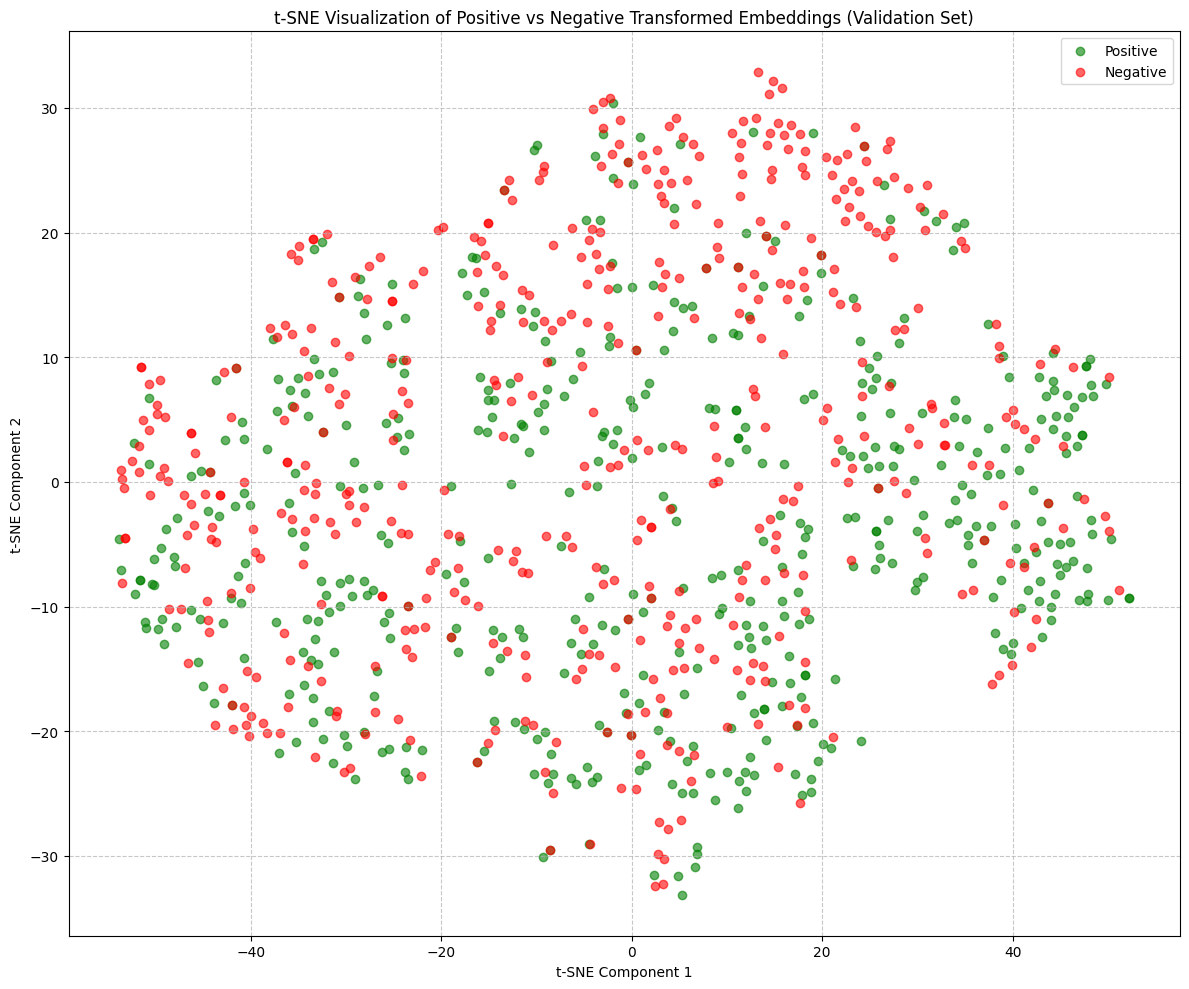


Validation Embedding Statistics:
Average Query-Positive Distance: 5.4400
Average Query-Negative Distance: 10.0788
Distance Ratio (Negative/Positive): 1.8527


In [11]:
import torch
import numpy as np
import faiss
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split

# Load the trained model
def load_trained_model(model_path, embedding_dim):
    from torch import nn
    
    # Define the model architecture (same as in your training code)
    class TripletEncoder(nn.Module):
        def __init__(self, embedding_dim):
            super(TripletEncoder, self).__init__()
            self.fc = nn.Sequential(
                nn.Linear(embedding_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128)
            )

        def forward(self, x):
            return self.fc(x)
    
    # Create model instance
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # First try to determine embedding dimension from saved model
    try:
        state_dict = torch.load(model_path, map_location=device)
        saved_embedding_dim = state_dict['fc.0.weight'].shape[1]
        print(f"Detected embedding dimension from saved model: {saved_embedding_dim}")
        model = TripletEncoder(saved_embedding_dim).to(device)
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model with detected dimensions: {e}")
        print(f"Trying with provided embedding dimension: {embedding_dim}")
        model = TripletEncoder(embedding_dim).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
    
    model.eval()
    return model, device

# Custom collate function to handle individual batches
def custom_collate_fn(batch):
    return batch  # Return as is, process individually

# Visualization script for validation set
def visualize_val_embeddings():
    print("Loading FAISS indices...")
    # Verify the correct paths to your indices
    query_index_path = "/home/mvyas7/TRIM-QA/Summer-Research/e5_queries_index.faiss"
    positive_index_path = "/home/mvyas7/TRIM-QA/Summer-Research/e5_positive_tables_index.faiss" 
    negative_index_path = "/home/mvyas7/TRIM-QA/Summer-Research/e5_negative_tables_index.faiss"
    metadata_file = "e5_triplet_embeddings_data.json"
    
    print(f"Loading indices from:")
    print(f"  - Queries: {query_index_path}")
    print(f"  - Positives: {positive_index_path}")
    print(f"  - Negatives: {negative_index_path}")
    print(f"  - Metadata: {metadata_file}")
    
    try:
        query_index = faiss.read_index(query_index_path)
        positive_index = faiss.read_index(positive_index_path)
        negative_index = faiss.read_index(negative_index_path)
    except Exception as e:
        print(f"Error loading FAISS indices: {e}")
        print("Please verify the paths to your indices are correct.")
        return
    
    embedding_dim = query_index.d
    print(f"Embedding dimension from FAISS index: {embedding_dim}")
    
    # Load the trained model
    model_path = "triplet_encoder_final.pth"  # or "best_model.pth"
    model, device = load_trained_model(model_path, embedding_dim)
    print(f"Model loaded from {model_path}")
    
    # Initialize dataset
    try:
        dataset = FAISSTripletDataset(
            metadata_file=metadata_file,
            query_index_path=query_index_path,
            positive_index_path=positive_index_path,
            negative_index_path=negative_index_path
        )
    except Exception as e:
        print(f"Error initializing dataset: {e}")
        return
    
    # Split dataset into training and validation (80/20 split)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    
    # Use a fixed seed for reproducibility
    generator = torch.Generator().manual_seed(42)
    _, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)
    
    print(f"Total dataset size: {len(dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    
    # Create data loader for validation set
    val_loader = DataLoader(
        val_dataset, 
        batch_size=1, 
        shuffle=False, 
        collate_fn=custom_collate_fn
    )
    
    # Get transformed embeddings from validation set
    query_embeddings, positive_embeddings, negative_embeddings = [], [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Processing validation embeddings"):
            for query_emb, pos_emb, neg_embs in batch:
                # Convert to tensors
                query = torch.tensor(query_emb, dtype=torch.float32).to(device)
                pos = torch.tensor(pos_emb, dtype=torch.float32).to(device)
                
                # Transform through model
                query_out = model(query).cpu().numpy()
                pos_out = model(pos).cpu().numpy()
                
                query_embeddings.append(query_out)
                positive_embeddings.append(pos_out)
                
                # Process one negative embedding per triplet
                if neg_embs:
                    neg = torch.tensor(neg_embs[0], dtype=torch.float32).to(device)
                    neg_out = model(neg).cpu().numpy()
                    negative_embeddings.append(neg_out)
    
    # Stack all embeddings
    if not query_embeddings or not positive_embeddings or not negative_embeddings:
        print("Error: No embeddings collected. Check your dataset and model.")
        return
        
    query_embeddings = np.vstack(query_embeddings)
    positive_embeddings = np.vstack(positive_embeddings)
    negative_embeddings = np.vstack(negative_embeddings)
    
    print(f"Collected {len(query_embeddings)} query, {len(positive_embeddings)} positive, and {len(negative_embeddings)} negative embeddings from validation set")
    
    # Sample if there are too many points for visualization
    max_points = 500
    if len(query_embeddings) > max_points:
        indices = np.random.choice(len(query_embeddings), max_points, replace=False)
        query_embeddings = query_embeddings[indices]
        positive_embeddings = positive_embeddings[indices]
        negative_embeddings = negative_embeddings[:max_points]
        print(f"Sampled {max_points} points for clearer visualization")
    
    # Combine all embeddings for dimensionality reduction
    all_embeddings = np.vstack([query_embeddings, positive_embeddings, negative_embeddings])
    labels = ['Query'] * len(query_embeddings) + ['Positive'] * len(positive_embeddings) + ['Negative'] * len(negative_embeddings)
    
    # Apply t-SNE for visualization
    print("Applying t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings)-1))
    tsne_result = tsne.fit_transform(all_embeddings)
    
    # Create visualization with 3 classes
    plt.figure(figsize=(12, 10))
    colors = {'Query': 'blue', 'Positive': 'green', 'Negative': 'red'}
    
    for label, color in colors.items():
        mask = [l == label for l in labels]
        plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1], c=color, label=label, alpha=0.6)
    
    plt.title('t-SNE Visualization of Transformed Embeddings (Validation Set)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('validation_embeddings_all.png')
    plt.show()
    
    # Also create a version just showing positives vs negatives
    plt.figure(figsize=(12, 10))
    
    # Get just the positives and negatives
    pos_neg_embeddings = np.vstack([positive_embeddings, negative_embeddings])
    pos_neg_labels = ['Positive'] * len(positive_embeddings) + ['Negative'] * len(negative_embeddings)
    
    # Apply t-SNE again for just positives and negatives
    tsne_pos_neg = TSNE(n_components=2, random_state=42, perplexity=min(30, len(pos_neg_embeddings)-1))
    tsne_result_pos_neg = tsne_pos_neg.fit_transform(pos_neg_embeddings)
    
    # Plot
    for label, color in {'Positive': 'green', 'Negative': 'red'}.items():
        mask = [l == label for l in pos_neg_labels]
        plt.scatter(tsne_result_pos_neg[mask, 0], tsne_result_pos_neg[mask, 1], c=color, label=label, alpha=0.6)
    
    plt.title('t-SNE Visualization of Positive vs Negative Transformed Embeddings (Validation Set)')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('validation_embeddings_pos_neg.png')
    plt.show()
    
    # Calculate and print some statistics about the validation embeddings
    print("\nValidation Embedding Statistics:")
    
    # Calculate average distances
    query_pos_dists = np.mean([np.linalg.norm(q - p) for q, p in zip(query_embeddings, positive_embeddings)])
    query_neg_dists = []
    
    for q in query_embeddings:
        for n in negative_embeddings:
            query_neg_dists.append(np.linalg.norm(q - n))
    
    avg_query_neg_dist = np.mean(query_neg_dists)
    
    print(f"Average Query-Positive Distance: {query_pos_dists:.4f}")
    print(f"Average Query-Negative Distance: {avg_query_neg_dist:.4f}")
    print(f"Distance Ratio (Negative/Positive): {avg_query_neg_dist / query_pos_dists:.4f}")

if __name__ == "__main__":
    visualize_val_embeddings()

# Inference on Test Set

Starting table retrieval and ranking optimization process
Using device: cuda
Loading E5 embedding model...
Loading optimized triplet model...
Loading tables from /home/mvyas7/TRIM-QA/Summer-Research/nq_tables/interactions/test.jsonl...


Processing tables: 966it [00:00, 15440.33it/s]


Successfully loaded 896 tables
Loading test data from /home/mvyas7/TRIM-QA/Summer-Research/nq_final_retrieval_result.xlsx...
Loaded 966 queries from test data
Excel file columns: ['QID', 'Orig Question', 'Decomposed question', 'Answer', 'Gold Table Id', 'Rank of Gold Table (None = Not in Top 100)', 'Top 50 (TableIds,score)']
Processing queries and reranking tables...


Processing queries:   0%|          | 0/966 [00:00<?, ?it/s]

/home/mvyas7/TRIM-QA/Summer-Research/summer-research-venv3/lib/python3.13/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Processing queries:   1%|          | 7/966 [00:00<01:03, 15.17it/s]

Skipping duplicate query text: who is the oldest wrestler that is still wrestling (skipped 1 so far)


Processing queries:   2%|▏         | 19/966 [00:01<00:47, 20.10it/s]

Query dev_-9123151742355474779_0_0: Gold table List of state and union territory capitals in India_CE852A3EE9186837 not in top 50, adding it manually


Processing queries:   3%|▎         | 28/966 [00:01<00:49, 19.12it/s]

Query dev_-8491157534197669091_0_0: Gold table 47th Academy Awards_4B3AF3F31AFC9AE6 not in top 50, adding it manually
Skipping duplicate query text: who is the premier of northern cape 2018 (skipped 2 so far)


Processing queries:   7%|▋         | 63/966 [00:03<00:52, 17.30it/s]

Skipping duplicate query text: which is the first private medical college in kerala (skipped 3 so far)
Skipping duplicate query text: who won the medals in men's figure skating 2018 (skipped 4 so far)


Processing queries:   7%|▋         | 67/966 [00:03<00:46, 19.30it/s]

Query dev_3724356943291190911_2_0: Gold table This Is Us (season 2)_E5717A0700AA4A53 not in top 50, adding it manually


Processing queries:   8%|▊         | 80/966 [00:04<00:40, 21.74it/s]

Skipping duplicate query text: who has become the new chairman of sebi (skipped 5 so far)


Processing queries:  11%|█         | 108/966 [00:05<00:34, 25.17it/s]

Skipping duplicate query text: when was last time bayern munich won champions league (skipped 6 so far)


Processing queries:  13%|█▎        | 122/966 [00:05<00:33, 25.55it/s]

Skipping duplicate query text: who is the richest club in the championship (skipped 7 so far)


Processing queries:  18%|█▊        | 178/966 [00:08<00:35, 22.41it/s]

Query dev_8193934593691670178_0_0: Gold table India national cricket team record by opponent_24BE43A3139EDD6C not in top 50, adding it manually
Skipping duplicate query text: how many scholarships do division 2 football teams get (skipped 8 so far)


Processing queries:  23%|██▎       | 222/966 [00:10<00:30, 24.46it/s]

Skipping duplicate query text: what is the pirates of the caribbean in order (skipped 9 so far)
Skipping duplicate query text: when is the last time the jaguars won a playoff game (skipped 10 so far)
Skipping duplicate query text: when is the last time the jaguars won a playoff game (skipped 11 so far)


Processing queries:  25%|██▌       | 246/966 [00:11<00:31, 23.03it/s]

Skipping duplicate query text: who has won the most college football national champions (skipped 12 so far)


Processing queries:  26%|██▌       | 253/966 [00:12<00:29, 23.79it/s]

Query dev_-1182093724333869887_1_0: Gold table Gina Tognoni_44A171225E5A5AB0 not in top 50, adding it manually


Processing queries:  28%|██▊       | 267/966 [00:12<00:28, 24.38it/s]

Skipping duplicate query text: what's the average lifespan of a basset hound (skipped 13 so far)


Processing queries:  29%|██▉       | 278/966 [00:13<00:25, 26.83it/s]

Skipping duplicate query text: who has been appointed as the election commissioner of india (skipped 14 so far)


Processing queries:  29%|██▉       | 281/966 [00:13<00:27, 25.22it/s]

Skipping duplicate query text: who won entertainer of the year country music awards (skipped 15 so far)


Processing queries:  33%|███▎      | 317/966 [00:15<00:29, 21.90it/s]

Query dev_7926179542568614934_1_0: Gold table 64th National Film Awards_80DD633BA69D7E65 not in top 50, adding it manually


Processing queries:  37%|███▋      | 361/966 [00:17<00:33, 18.31it/s]

Skipping duplicate query text: when did michigan last win a national championship (skipped 16 so far)


Processing queries:  38%|███▊      | 367/966 [00:17<00:31, 18.80it/s]

Skipping duplicate query text: who won the mens figure skating in 2018 olympics (skipped 17 so far)
Query dev_-2871436317021473624_0_0: Gold table List of The Flash episodes_9CD98D276C3EEC0B not in top 50, adding it manually


Processing queries:  39%|███▉      | 375/966 [00:18<00:31, 19.03it/s]

Skipping duplicate query text: who represents the arizona 9th district in the house (skipped 18 so far)


Processing queries:  40%|███▉      | 383/966 [00:18<00:23, 24.97it/s]

Skipping duplicate query text: what was vietnam called in the years before world war 2 (skipped 19 so far)


Processing queries:  42%|████▏     | 410/966 [00:20<00:26, 21.21it/s]

Skipping duplicate query text: most passing yards in nfl history in a game (skipped 20 so far)


Processing queries:  48%|████▊     | 465/966 [00:22<00:27, 18.41it/s]

Skipping duplicate query text: what was the last episode of the flash (skipped 21 so far)


Processing queries:  49%|████▉     | 471/966 [00:23<00:25, 19.65it/s]

Skipping duplicate query text: who is the secretary of state for northern ireland (skipped 22 so far)
Query dev_7143040220722532389_0_0: Gold table List of Emily Dickinson poems_B0BCB66A872F8BA1 not in top 50, adding it manually


Processing queries:  52%|█████▏    | 502/966 [00:24<00:24, 18.66it/s]

Skipping duplicate query text: host of the late show who was once a correspondent for the daily show (skipped 23 so far)
Skipping duplicate query text: who won the mens single ice skating 2018 (skipped 24 so far)
Skipping duplicate query text: who won the mens single ice skating 2018 (skipped 25 so far)


Processing queries:  54%|█████▍    | 526/966 [00:26<00:19, 22.34it/s]

Skipping duplicate query text: who won last year's ncaa women's basketball (skipped 26 so far)


Processing queries:  55%|█████▌    | 535/966 [00:26<00:23, 18.70it/s]

Skipping duplicate query text: when was the last time america hosted the summer olympics (skipped 27 so far)


Processing queries:  59%|█████▉    | 570/966 [00:28<00:17, 22.43it/s]

Skipping duplicate query text: when's the last time michigan won a national championship in basketball (skipped 28 so far)


Processing queries:  60%|█████▉    | 576/966 [00:28<00:20, 18.83it/s]

Query dev_6347689646333822132_0_0: Gold table Detroit Tigers_9731F5587A6E08DB not in top 50, adding it manually
Query dev_-4723713582700509339_0_0: Gold table List of cities proper by population_E66CC7A1603F964C not in top 50, adding it manually


Processing queries:  61%|██████    | 586/966 [00:29<00:20, 18.50it/s]

Skipping duplicate query text: where did zendaya place in dancing with the stars (skipped 29 so far)
Query dev_5543510584551366341_1_0: Gold table Celebrity Big Brother (U.S. TV series)_1347C74C6B5C58D7 not in top 50, adding it manually


Processing queries:  62%|██████▏   | 601/966 [00:29<00:14, 25.14it/s]

Skipping duplicate query text: who is the highest selling r&b artist of all time (skipped 30 so far)


Processing queries:  64%|██████▍   | 623/966 [00:30<00:14, 24.36it/s]

Query dev_-2470596760323857939_0_0: Gold table Battles of Saratoga_26FA72689060A7C0 not in top 50, adding it manually


Processing queries:  65%|██████▌   | 629/966 [00:30<00:13, 25.20it/s]

Skipping duplicate query text: who is the chief economic advisor of india (skipped 31 so far)
Query dev_-8622455892578646005_0_0: Gold table List of career achievements by Tiger Woods_73BC4D58877D5CA3 not in top 50, adding it manually


Processing queries:  66%|██████▌   | 637/966 [00:31<00:13, 24.93it/s]

Skipping duplicate query text: who did cubs beat in 2016 world series (skipped 32 so far)


Processing queries:  67%|██████▋   | 648/966 [00:31<00:11, 27.75it/s]

Query dev_-6154199957062906148_1_0: Gold table Merseyside derby_48B7DE82844E0424 not in top 50, adding it manually
Skipping duplicate query text: who has played in the most premier league derbies (skipped 33 so far)


Processing queries:  68%|██████▊   | 661/966 [00:32<00:17, 17.75it/s]

Skipping duplicate query text: what is the most current adobe flash player version (skipped 34 so far)
Query dev_-6482446475869649556_0_0: Gold table And I Am Telling You I'm Not Going_F0AEA20BD1FDF994 not in top 50, adding it manually


Processing queries:  69%|██████▉   | 667/966 [00:32<00:16, 18.27it/s]

Skipping duplicate query text: who has won more national championships michigan or ohio state (skipped 35 so far)


Processing queries:  76%|███████▌  | 736/966 [00:36<00:10, 21.39it/s]

Skipping duplicate query text: when does grey's anatomy come back on in march (skipped 36 so far)


Processing queries:  77%|███████▋  | 743/966 [00:36<00:08, 26.13it/s]

Query dev_8948147123900423867_0_0: Gold table America's Next Top Model (cycle 24)_26FA63D4FAF450E not in top 50, adding it manually


Processing queries:  78%|███████▊  | 749/966 [00:36<00:08, 24.29it/s]

Skipping duplicate query text: who won the american league pennant in 2017 (skipped 37 so far)


Processing queries:  81%|████████  | 779/966 [00:38<00:08, 21.19it/s]

Query dev_-4037051475431138092_0_0: Gold table Gupta Empire_1D283F3FC715FF13 not in top 50, adding it manually
Query dev_1533485886147206292_0_0: Gold table List of Super Bowl champions_FEA99A86D1AC4EE5 not in top 50, adding it manually
Query dev_-4187551720360968088_0_0: Gold table List of Formula One driver records_F5D8E6BADD132281 not in top 50, adding it manually


Processing queries:  82%|████████▏ | 789/966 [00:38<00:09, 19.54it/s]

Query dev_-1991117775599650072_0_0: Gold table Say Something_BDBB8FED0441B8E0 not in top 50, adding it manually


Processing queries:  83%|████████▎ | 798/966 [00:39<00:07, 21.57it/s]

Query dev_6174757067560312593_0_0: Gold table Can't Stop the Feeling!_273BEC171DC01F55 not in top 50, adding it manually


Processing queries:  84%|████████▍ | 812/966 [00:40<00:09, 15.73it/s]

Query dev_-8581011797354123346_0_0: Gold table List of Marvel Cinematic Universe television series_ED3F73F3D0F2F1C not in top 50, adding it manually
Query dev_4012602576624292720_0_0: Gold table 2006 FIFA World Cup_84D4298EE86B1799 not in top 50, adding it manually


Processing queries:  85%|████████▍ | 819/966 [00:40<00:07, 18.66it/s]

Skipping duplicate query text: chief ministers of tamil nadu mentioned on wikipedia (skipped 38 so far)
Skipping duplicate query text: the secret of crickley hall how many episodes (skipped 39 so far)


Processing queries:  87%|████████▋ | 841/966 [00:41<00:05, 23.55it/s]

Skipping duplicate query text: when was the last time an american won the new york marathon (skipped 40 so far)
Skipping duplicate query text: who is the longest serving member of the house in history (skipped 41 so far)


Processing queries:  88%|████████▊ | 850/966 [00:42<00:06, 17.94it/s]

Skipping duplicate query text: where does the path train stop in newark (skipped 42 so far)


Processing queries:  93%|█████████▎| 899/966 [00:44<00:03, 19.48it/s]

Skipping duplicate query text: when is the new dumping ground coming out 2017 (skipped 43 so far)
Skipping duplicate query text: when was the last time michigan basketball won the championship (skipped 44 so far)
Skipping duplicate query text: when was the last time michigan basketball won the championship (skipped 45 so far)


Processing queries:  95%|█████████▍| 916/966 [00:45<00:02, 21.54it/s]

Skipping duplicate query text: who plays lefou in beauty and the beast 1991 (skipped 46 so far)


Processing queries:  95%|█████████▌| 919/966 [00:45<00:02, 21.03it/s]

Query dev_-3585157729928173881_0_0: Gold table Marvel Animated Features_A9516B7C83E0862D not in top 50, adding it manually


Processing queries:  96%|█████████▋| 931/966 [00:46<00:01, 23.20it/s]

Query dev_8518872418407042794_0_0: Gold table Joe Gibbs Racing_5266103C458DA019 not in top 50, adding it manually


Processing queries:  97%|█████████▋| 940/966 [00:46<00:01, 18.36it/s]

Query dev_6536528459363538848_1_0: Gold table List of The Next Step episodes_EE94E79E08CC40D3 not in top 50, adding it manually
Query dev_-1617333894100895364_0_0: Gold table 114th United States Congress_20629AB2BE4CB3A not in top 50, adding it manually
Query dev_1119012929351784703_0_0: Gold table United States_203963EE8FFA0 not in top 50, adding it manually


Processing queries:  98%|█████████▊| 946/966 [00:46<00:01, 18.65it/s]

Query dev_-531589262767128245_0_0: Gold table List of Spanish football champions_49A4AAAD316FA493 not in top 50, adding it manually
Skipping duplicate query text: who won the national championship in volleyball 2017 (skipped 47 so far)


Processing queries: 100%|██████████| 966/966 [00:47<00:00, 20.20it/s]


Processed 919 unique queries (skipped 47 duplicates)
Calculating metrics...
Query #15: Not considered valid - Original rank is None but optimized rank is 2
Query #24: Not considered valid - Original rank is None but optimized rank is 1
Query #63: Not considered valid - Original rank is None but optimized rank is 1
Query #300: Not considered valid - Original rank is None but optimized rank is 1
Query #450: Not considered valid - Original rank is None but optimized rank is 1
Query #548: Not considered valid - Original rank is None but optimized rank is 3
Query #589: Not considered valid - Original rank is None but optimized rank is 1
Query #614: Not considered valid - Original rank is None but optimized rank is 2
Query #625: Not considered valid - Original rank is None but optimized rank is 1
Query #702: Not considered valid - Original rank is None but optimized rank is 1
Query #739: Not considered valid - Original rank is None but optimized rank is 1
Query #740: Not considered valid - O

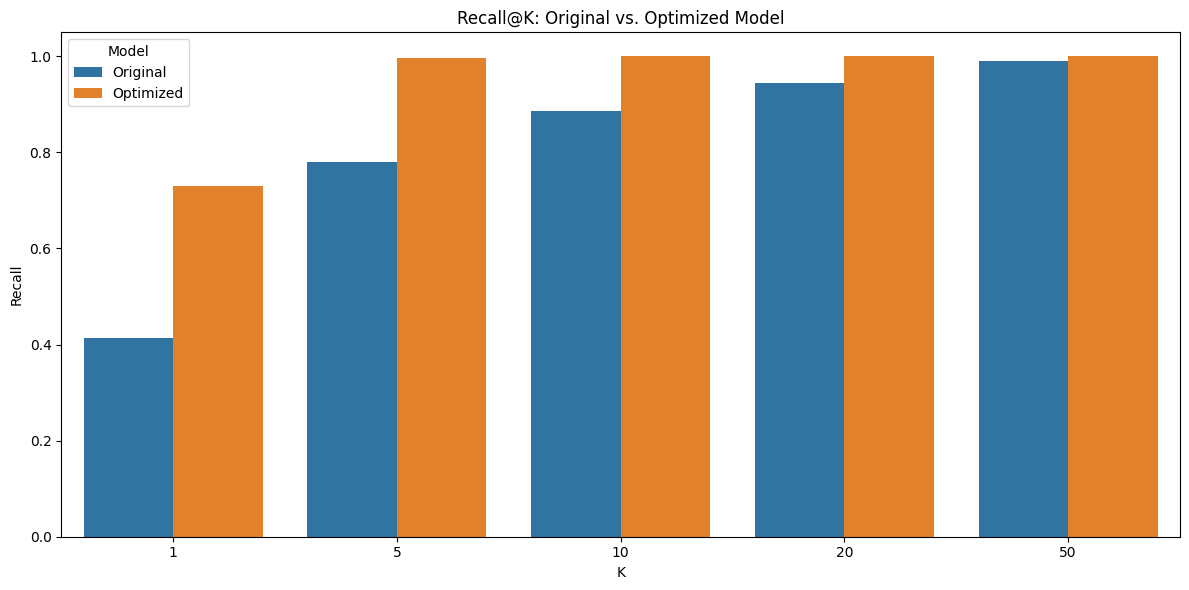

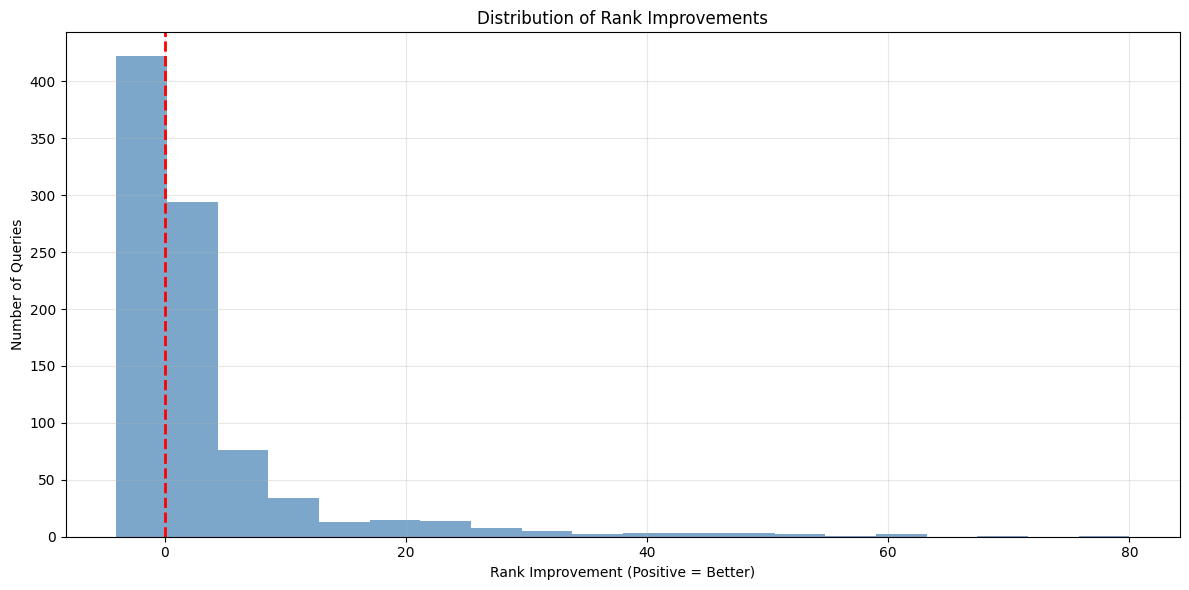

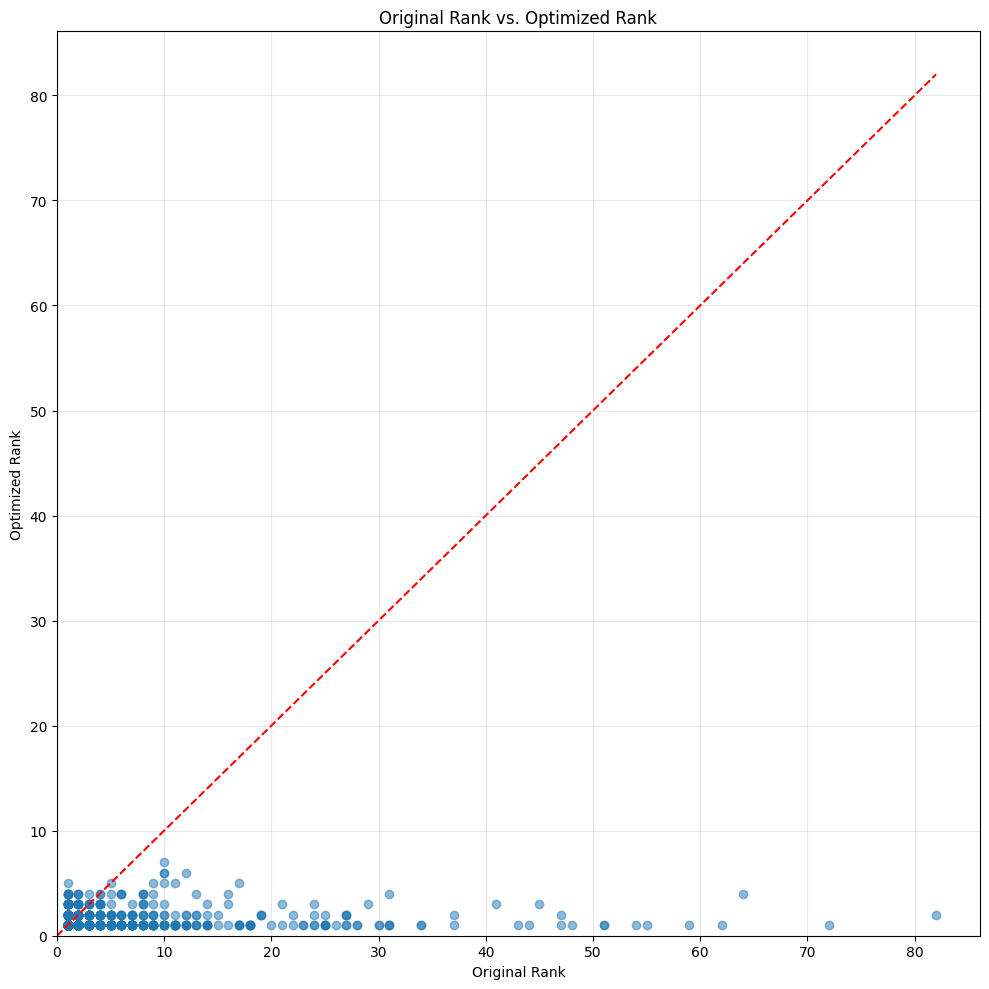

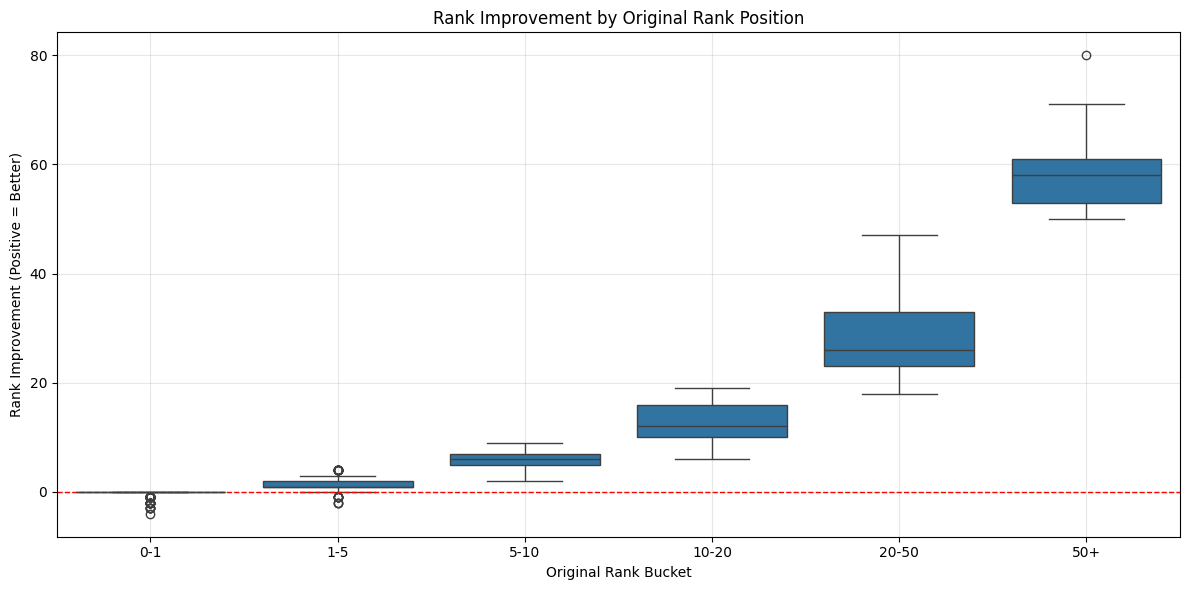

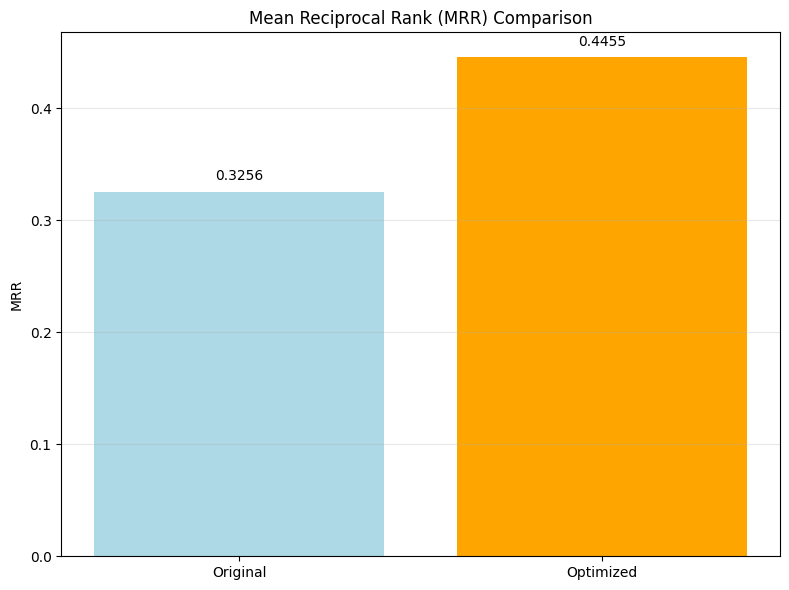

In [8]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from typing import List, Dict, Tuple, Optional, Union

# Define paths
MODEL_PATH = "/home/mvyas7/TRIM-QA/Summer-Research/optimized_triplet_model.pth"
TEST_DATA_PATH = "/home/mvyas7/TRIM-QA/Summer-Research/nq_final_retrieval_result.xlsx"
TABLES_PATH = "/home/mvyas7/TRIM-QA/Summer-Research/nq_tables/interactions/test.jsonl"
OUTPUT_DIR = "/home/mvyas7/TRIM-QA/Summer-Research/results"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
MAX_SEQ_LENGTH = 512
RECALL_POSITIONS = [1, 5, 10, 20, 50]  # Recall@K positions to evaluate

class EnhancedTripletEncoder(nn.Module):
    """
    Neural network to transform embeddings into a more semantically meaningful space
    by applying the triplet loss optimization learned during training.
    """
    def __init__(self, embedding_dim=1024, dropout_rate=0.2):
        super(EnhancedTripletEncoder, self).__init__()
        # First layer
        self.fc1 = nn.Linear(embedding_dim, 512)
        self.norm1 = nn.LayerNorm(512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second layer
        self.fc2 = nn.Linear(512, 256)
        self.norm2 = nn.LayerNorm(256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Third layer
        self.fc3 = nn.Linear(256, 128)
        
        # L2 normalization of final embeddings
        self.normalize_output = True
        
    def forward(self, x):
        # First layer
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        # Second layer
        x = self.fc2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        # Third layer
        x = self.fc3(x)
        
        # L2 normalization
        if self.normalize_output:
            x = F.normalize(x, p=2, dim=1)
            
        return x

def load_jsonl_tables(file_path: str) -> Dict[str, dict]:
    """
    Load all tables from JSONL file into a dictionary keyed by tableId.
    
    Args:
        file_path: Path to the JSONL file containing table data
        
    Returns:
        Dictionary mapping table IDs to table data
    """
    tables = {}
    
    print(f"Loading tables from {file_path}...")
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Processing tables"):
            if not line.strip():
                continue
                
            try:
                item = json.loads(line)
                if 'table' in item and 'tableId' in item['table']:
                    table_id = item['table']['tableId']
                    tables[table_id] = item['table']
            except json.JSONDecodeError:
                print(f"Error parsing JSON line: {line[:100]}...")
                
    print(f"Successfully loaded {len(tables)} tables")
    return tables

def prepare_table_text(table_data: dict) -> str:
    """
    Convert table data into a structured text representation for embedding.
    
    Args:
        table_data: Dictionary containing table data
        
    Returns:
        Formatted string representation of the table
    """
    # Start with document title
    doc_title = table_data.get('documentTitle', '')
    text_parts = [f"Title: {doc_title}"]
    
    # Extract column headers
    if 'columns' in table_data:
        headers = [col.get('text', '') for col in table_data['columns']]
        headers_text = ' | '.join(header for header in headers if header)
        text_parts.append(f"Headers: {headers_text}")
    
    # Extract rows
    if 'rows' in table_data:
        for i, row in enumerate(table_data['rows']):
            if 'cells' in row:
                row_values = [cell.get('text', '') for cell in row['cells']]
                row_text = ' | '.join(value for value in row_values if value)
                text_parts.append(f"Row {i+1}: {row_text}")
    
    return '\n'.join(text_parts)

def parse_top_tables(top_tables_str: str) -> List[str]:
    """
    Parse the top tables string into a list of table IDs.
    
    Args:
        top_tables_str: String representation of top tables with scores
        
    Returns:
        List of table IDs
    """
    if isinstance(top_tables_str, list):
        # Already a list
        return [item[0] for item in top_tables_str] if top_tables_str and isinstance(top_tables_str[0], tuple) else top_tables_str
    
    try:
        # Try to evaluate as Python literal (list of tuples)
        tables_with_scores = eval(top_tables_str)
        return [item[0] for item in tables_with_scores]
    except:
        # If that fails, try other formats
        if isinstance(top_tables_str, str):
            if '[' in top_tables_str and '(' in top_tables_str:
                # Try to extract table IDs using string manipulation
                parts = top_tables_str.replace('[', '').replace(']', '').split('),')
                return [p.split("'")[1] for p in parts if "'" in p]
            else:
                # Simple comma or space separated list
                return top_tables_str.replace(',', ' ').split()
    
    print(f"Warning: Could not parse top tables: {top_tables_str[:100]}...")
    return []

def generate_embeddings(tokenizer, model, texts: List[str], prefix: str, batch_size: int = 8) -> torch.Tensor:
    """
    Generate embeddings for a list of texts using the specified model.
    
    Args:
        tokenizer: Tokenizer for the model
        model: Model to use for generating embeddings
        texts: List of texts to embed
        prefix: Prefix to add to each text ('query: ' or 'passage: ')
        batch_size: Batch size for processing
        
    Returns:
        Tensor of embeddings
    """
    # Add the appropriate prefix to each text
    prefixed_texts = [f"{prefix} {text}" for text in texts]
    all_embeddings = []
    
    # Process in batches
    for i in range(0, len(prefixed_texts), batch_size):
        batch_texts = prefixed_texts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch_texts, 
            padding=True, 
            truncation=True, 
            max_length=MAX_SEQ_LENGTH, 
            return_tensors="pt"
        ).to(DEVICE)
        
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            # Get CLS token embedding (first token)
            embeddings = outputs.last_hidden_state[:, 0]
            # Normalize
            embeddings = F.normalize(embeddings, p=2, dim=1)
            all_embeddings.append(embeddings)
    
    # Concatenate all batch embeddings
    if all_embeddings:
        return torch.cat(all_embeddings, dim=0)
    else:
        return torch.tensor([])

def calculate_recall_at_k(gold_ranks: List[Optional[int]], k_values: List[int]) -> Dict[str, float]:
    """
    Calculate recall@k for each k in k_values.
    
    Args:
        gold_ranks: List of ranks (positions) of gold tables
        k_values: List of k values to calculate recall for
        
    Returns:
        Dictionary of recall values for each k
    """
    results = {}
    
    for k in k_values:
        # For each query, check if gold table is in top-k
        recall = sum(1 for rank in gold_ranks if rank is not None and rank <= k) / max(1, len(gold_ranks))
        results[f'recall@{k}'] = recall
    
    return results

def calculate_mrr(gold_ranks: List[Optional[int]]) -> float:
    """
    Calculate Mean Reciprocal Rank.
    
    Args:
        gold_ranks: List of ranks (positions) of gold tables
        
    Returns:
        Mean Reciprocal Rank value
    """
    # Reciprocal rank is 1/rank (add 1 to rank since ranks are 0-indexed)
    reciprocal_ranks = [1/(rank+1) if rank is not None else 0 for rank in gold_ranks]
    return sum(reciprocal_ranks) / max(1, len(reciprocal_ranks))

def main():
    print(f"Starting table retrieval and ranking optimization process")
    print(f"Using device: {DEVICE}")
    
    # Step 1: Load the E5 embedding model
    print("Loading E5 embedding model...")
    e5_model_name = "intfloat/e5-large-v2"
    e5_tokenizer = AutoTokenizer.from_pretrained(e5_model_name)
    e5_model = AutoModel.from_pretrained(e5_model_name).to(DEVICE)
    e5_model.eval()
    
    # Step 2: Load the optimized triplet model
    print("Loading optimized triplet model...")
    triplet_model = EnhancedTripletEncoder(embedding_dim=1024).to(DEVICE)
    triplet_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    triplet_model.eval()
    
    # Step 3: Load all tables from test.jsonl
    all_tables = load_jsonl_tables(TABLES_PATH)
    
    # Step 4: Load test data from Excel
    print(f"Loading test data from {TEST_DATA_PATH}...")
    df = pd.read_excel(TEST_DATA_PATH)
    print(f"Loaded {len(df)} queries from test data")

    # Identify and track unique query texts to avoid processing duplicates
    processed_query_text = set()
    
    # Display columns for debugging
    print("Excel file columns:", df.columns.tolist())
    
    # Initialize result storage
    results = []
    original_gold_ranks = []
    optimized_gold_ranks = []
    
    # Process each query
    print("Processing queries and reranking tables...")
    skipped_count = 0

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing queries"):
        # Extract query information
        query_id = row['QID'] if 'QID' in df.columns else (row['query_id'] if 'query_id' in df.columns else None)

        # Extract orig query text
        query_text_original = row['Orig Question'] if 'Orig Question' in df.columns else (row['query'] if 'query' in df.columns else None)

        if query_id is None:
            print("Error: Could not find query ID column")
            continue

        # Skip if we've already processed this query text
        if query_text_original in processed_query_text:
            skipped_count += 1
            print(f"Skipping duplicate query text: {query_text_original} (skipped {skipped_count} so far)")
            continue

        # Mark this query text as processed
        processed_query_text.add(query_text_original)

        # Extract question text
        question = None
        col_name = 'Orig Question'
        if col_name in df.columns and pd.notna(row[col_name]):
            question = row[col_name]

        if question is None:
            print(f"Warning: No question text found for query {query_id}")
            continue
        
        # Extract decomposed question if available
        decomposed_question = None
        decomposed_col_name = 'Decomposed question'
        if decomposed_col_name in df.columns and pd.notna(row[decomposed_col_name]):
            decomposed_question = row[decomposed_col_name]

        # Use decomposed question if available, otherwise use original
        query_text = decomposed_question if decomposed_question else question
        
        # Extract gold table ID
        gold_table_id = None
        for col_name in ['Gold Table ID', 'Gold Table Id']:
            if col_name in df.columns and pd.notna(row[col_name]):
                gold_table_id = row[col_name]
                break
        
        # Extract original rank
        original_rank = None
        for col_name in ['Rank of Gold', 'Rank of Gold Table (None = Not in Top 100)']:
            if col_name in df.columns and pd.notna(row[col_name]):
                original_rank = row[col_name]
                break
        # print if the irgia]nal rank is None 
        if original_rank is not None:
            original_rank = int(original_rank) if isinstance(original_rank, (int, float)) else None
        else:
            print(f"Warning: No original rank found for query {query_id}")
        original_gold_ranks.append(original_rank if original_rank is not None else None)
        
        # Extract top 50 table IDs
        top_50_tables_str = None
        for col_name in ['Top 50 Table Array', 'Top 50 (TableIds,score)', 'Top 50 Tables']:
            if col_name in df.columns and pd.notna(row[col_name]):
                top_50_tables_str = row[col_name]
                break
                
        if top_50_tables_str is None:
            print(f"No top 50 tables found for query {query_id}")
            optimized_gold_ranks.append(None)
            continue
            
        # Parse top 50 tables string to get table IDs
        top_50_table_ids = parse_top_tables(top_50_tables_str)

        # Check if gold table ID is in top 50
        if gold_table_id and gold_table_id not in top_50_table_ids:
            # Gold table exists but isn't in top 50, add it to the list
            top_50_table_ids.append(gold_table_id)
            print(f"Query {query_id}: Gold table {gold_table_id} not in top 50, adding it manually")
        
        if not top_50_table_ids:
            print(f"Error parsing top 50 tables for query {query_id}")
            optimized_gold_ranks.append(None)
            continue
        
        # Prepare table texts for each table ID
        table_texts = []
        valid_table_ids = []
        
        for table_id in top_50_table_ids:
            if table_id in all_tables:
                table_text = prepare_table_text(all_tables[table_id])
                table_texts.append(table_text)
                valid_table_ids.append(table_id)
        
        if not table_texts:
            print(f"No valid tables found for query {query_id}")
            optimized_gold_ranks.append(None)
            continue
        
        # Generate E5 embeddings for query
        query_embedding = generate_embeddings(
            e5_tokenizer, 
            e5_model, 
            [query_text], 
            "query:", 
            batch_size=1
        )
        
        # Generate E5 embeddings for tables
        table_embeddings = generate_embeddings(
            e5_tokenizer, 
            e5_model, 
            table_texts, 
            "passage:", 
            batch_size=BATCH_SIZE
        )
        
        if query_embedding.size(0) == 0 or table_embeddings.size(0) == 0:
            print(f"Failed to generate embeddings for query {query_id}")
            optimized_gold_ranks.append(None)
            continue
        
        # Transform through the triplet model
        with torch.no_grad():
            transformed_query_embedding = triplet_model(query_embedding)
            transformed_table_embeddings = triplet_model(table_embeddings)
        
        # Compute similarity scores (dot product in the transformed space)
        similarities = torch.matmul(transformed_query_embedding, transformed_table_embeddings.t())
        similarities = similarities.squeeze().cpu().numpy()
        
        # Rank tables based on similarity
        ranked_indices = np.argsort(-similarities)  # Descending order
        ranked_table_ids = [valid_table_ids[i] for i in ranked_indices]
        
        # Find rank of gold table in optimized results
        optimized_rank = None
        if gold_table_id in ranked_table_ids:
            # Add 1 to make ranks start from 1 instead of 0
            optimized_rank = ranked_table_ids.index(gold_table_id) + 1
            # print(f"Query {query_id}: Gold table {gold_table_id} found at position {optimized_rank} (was {original_rank})")
        else:
            print(f"Query {query_id}: Gold table {gold_table_id} not found in top ranked tables")
        
        optimized_gold_ranks.append(optimized_rank)
        
        # Store detailed results
        results.append({
            'query_id': query_id,
            'question': query_text,
            'gold_table_id': gold_table_id,
            'original_rank': original_rank,
            'optimized_rank': optimized_rank,
            'top_5_tables': ranked_table_ids[:5],
            'original_in_top_5': original_rank is not None and original_rank < 5,
            'optimized_in_top_5': optimized_rank is not None and optimized_rank < 5,
            'rank_change': None if original_rank is None or optimized_rank is None 
                          else original_rank - optimized_rank
        })

    print(f"Processed {len(processed_query_text)} unique queries (skipped {skipped_count} duplicates)")

    # Calculate metrics
    print("Calculating metrics...")
    
    # Filter out None values for valid comparisons
    valid_pairs = []
    none_original_count = 0
    none_optimized_count = 0
    both_none_count = 0
    
    for i, (orig, opt) in enumerate(zip(original_gold_ranks, optimized_gold_ranks)):
        if orig is None and opt is None:
            both_none_count += 1
        elif orig is None:
            none_original_count += 1
            print(f"Query #{i+1}: Not considered valid - Original rank is None but optimized rank is {opt}")
        elif opt is None:
            none_optimized_count += 1
            print(f"Query #{i+1}: Not considered valid - Optimized rank is None but original rank is {orig}")
        else:
            valid_pairs.append((orig, opt))
    
    print(f"Filtering results: {none_original_count} queries had None original rank, "
          f"{none_optimized_count} had None optimized rank, and {both_none_count} had both None")
    print(f"Total valid pairs for comparison: {len(valid_pairs)}")
    
    if not valid_pairs:
        print("No valid rankings to evaluate. Please check the data.")
        return
    
    valid_original_ranks = [orig for orig, _ in valid_pairs]
    valid_optimized_ranks = [opt for _, opt in valid_pairs]
    
    # Recall metrics
    original_recall = calculate_recall_at_k(valid_original_ranks, RECALL_POSITIONS)
    optimized_recall = calculate_recall_at_k(valid_optimized_ranks, RECALL_POSITIONS)
    
    # MRR
    original_mrr = calculate_mrr(valid_original_ranks)
    optimized_mrr = calculate_mrr(valid_optimized_ranks)
    
    # Print results
    print("\n===== RETRIEVAL PERFORMANCE RESULTS =====")
    print(f"Total test queries: {len(df)}")
    print(f"Queries with valid rankings: {len(valid_pairs)}")
    
    print("\nRecall Metrics:")
    for k in RECALL_POSITIONS:
        orig_recall = original_recall[f'recall@{k}']
        opt_recall = optimized_recall[f'recall@{k}']
        diff = opt_recall - orig_recall
        perc_change = (diff / orig_recall) * 100 if orig_recall > 0 else float('inf')
        
        print(f"Recall@{k}:")
        print(f"  Original:  {orig_recall:.4f}")
        print(f"  Optimized: {opt_recall:.4f}")
        print(f"  Difference: {diff:.4f} ({perc_change:.2f}%)")
    
    print("\nMean Reciprocal Rank (MRR):")
    mrr_diff = optimized_mrr - original_mrr
    mrr_perc_change = (mrr_diff / original_mrr) * 100 if original_mrr > 0 else float('inf')
    print(f"  Original:  {original_mrr:.4f}")
    print(f"  Optimized: {optimized_mrr:.4f}")
    print(f"  Difference: {mrr_diff:.4f} ({mrr_perc_change:.2f}%)")
    
    # Rank improvement analysis
    rank_improvements = [orig - opt for orig, opt in valid_pairs]
    avg_rank_improvement = np.mean(rank_improvements)
    median_rank_improvement = np.median(rank_improvements)
    
    print("\nRank Improvement Analysis:")
    print(f"  Average Rank Improvement: {avg_rank_improvement:.2f} positions")
    print(f"  Median Rank Improvement: {median_rank_improvement:.2f} positions")
    
    improved_count = sum(1 for x in rank_improvements if x > 0)
    same_count = sum(1 for x in rank_improvements if x == 0)
    worse_count = sum(1 for x in rank_improvements if x < 0)
    
    print(f"  Queries with Improved Ranking: {improved_count} ({improved_count/len(rank_improvements)*100:.2f}%)")
    print(f"  Queries with Same Ranking: {same_count} ({same_count/len(rank_improvements)*100:.2f}%)")
    print(f"  Queries with Worse Ranking: {worse_count} ({worse_count/len(rank_improvements)*100:.2f}%)")
    
    # Save detailed results to CSV
    results_df = pd.DataFrame(results)
    results_csv_path = os.path.join(OUTPUT_DIR, "optimized_model_evaluation_results.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nDetailed results saved to {results_csv_path}")
    
    # Create visualizations
    print("\nGenerating visualizations...")
    
    # 1. Recall comparison bar chart
    plt.figure(figsize=(12, 6))
    recalls = pd.DataFrame({
        'k': RECALL_POSITIONS * 2,
        'Recall': [original_recall[f'recall@{k}'] for k in RECALL_POSITIONS] + 
                  [optimized_recall[f'recall@{k}'] for k in RECALL_POSITIONS],
        'Model': ['Original'] * len(RECALL_POSITIONS) + ['Optimized'] * len(RECALL_POSITIONS)
    })
    
    sns.barplot(x='k', y='Recall', hue='Model', data=recalls)
    plt.title('Recall@K: Original vs. Optimized Model')
    plt.xlabel('K')
    plt.ylabel('Recall')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'recall_comparison.png'))
    
    # 2. Rank improvement histogram
    plt.figure(figsize=(12, 6))
    plt.hist(rank_improvements, bins=20, color='steelblue', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.title('Distribution of Rank Improvements')
    plt.xlabel('Rank Improvement (Positive = Better)')
    plt.ylabel('Number of Queries')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rank_improvement_hist.png'))
    
    # 3. Scatter plot of original vs. optimized ranks
    plt.figure(figsize=(10, 10))
    plt.scatter(valid_original_ranks, valid_optimized_ranks, alpha=0.5)
    max_val = max(max(valid_original_ranks), max(valid_optimized_ranks))
    plt.plot([0, max_val], [0, max_val], 'r--')  # Diagonal line
    plt.title('Original Rank vs. Optimized Rank')
    plt.xlabel('Original Rank')
    plt.ylabel('Optimized Rank')
    plt.xlim(0, max_val * 1.05)
    plt.ylim(0, max_val * 1.05)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rank_scatter.png'))
    
    # 4. Improvement by original rank position
    plt.figure(figsize=(12, 6))
    improvement_data = pd.DataFrame({
        'Original Rank': valid_original_ranks,
        'Improvement': rank_improvements
    })
    
    # Calculate the maximum rank dynamically to ensure monotonically increasing bins
    max_rank = max(valid_original_ranks)

    # Create dynamic bins that ensure monotonicity
    if max_rank <= 1:
        bins = [0, 1]
        labels = ['0-1']
    elif max_rank <= 5:
        bins = [0, 1, 5]
        labels = ['0-1', '1-5']
    elif max_rank <= 10:
        bins = [0, 1, 5, 10]
        labels = ['0-1', '1-5', '5-10']
    elif max_rank <= 20:
        bins = [0, 1, 5, 10, 20]
        labels = ['0-1', '1-5', '5-10', '10-20']
    elif max_rank <= 50:
        bins = [0, 1, 5, 10, 20, 50]
        labels = ['0-1', '1-5', '5-10', '10-20', '20-50']
    else:
        bins = [0, 1, 5, 10, 20, 50, max_rank]
        labels = ['0-1', '1-5', '5-10', '10-20', '20-50', '50+']

    # Apply the binning with the dynamically determined bins
    improvement_data['Rank Bucket'] = pd.cut(improvement_data['Original Rank'], bins=bins, labels=labels)
    
    sns.boxplot(x='Rank Bucket', y='Improvement', data=improvement_data)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('Rank Improvement by Original Rank Position')
    plt.xlabel('Original Rank Bucket')
    plt.ylabel('Rank Improvement (Positive = Better)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'improvement_by_rank.png'))
    
    # 5. MRR comparison
    plt.figure(figsize=(8, 6))
    plt.bar(['Original', 'Optimized'], [original_mrr, optimized_mrr], color=['lightblue', 'orange'])
    plt.title('Mean Reciprocal Rank (MRR) Comparison')
    plt.ylabel('MRR')
    for i, v in enumerate([original_mrr, optimized_mrr]):
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
    plt.grid(alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'mrr_comparison.png'))
    
    print(f"Visualizations saved to {OUTPUT_DIR}")
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()